In [1]:
! pip install yfinance

In [16]:
!pip install scikit-learn

In [184]:
!pip install statsmodels==0.12.1

  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0


In [41]:
!pip install eli5

  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107735 sha256=87b3da72d2ae227044289457b8d183fe9b216698afae2fadce53cc841a0a045a
  Stored in directory: c:\users\alexandre arriaga\appdata\local\pip\cache\wheels\85\ac\25\ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 1.1.1
    Uninstalling MarkupSafe-1.1.1:
      Successfully uninstalled MarkupSafe-1.1.1
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.2
    Uninstalling Jinja2-2.11.2:
      Successfully uninstalled Jinja2-2.11.2


In [8]:
import pandas as pd
import csv
import yfinance as yf
from datetime import date
import numpy as np
import random
from statistics import mean
from collinearity import SelectNonCollinear
from scipy.stats import uniform
from scipy.stats import randint
import itertools
import dateutil.parser
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
import sklearn
from sklearn import datasets, svm
import sklearn.metrics as skl
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing as pp
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_colwidth', None)

In [9]:
#### COVID Data Import ####
covid_data=pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
covid_data = covid_data[covid_data['location']== 'Portugal']
covid_data=covid_data.drop(columns=['iso_code','continent','location','total_cases','new_cases_smoothed','total_deaths','new_deaths_smoothed','total_cases_per_million','new_cases_per_million','new_cases_smoothed_per_million','total_deaths_per_million','new_deaths_per_million','new_deaths_smoothed_per_million','reproduction_rate','icu_patients_per_million','hosp_patients_per_million','weekly_icu_admissions','weekly_icu_admissions_per_million','weekly_hosp_admissions','weekly_hosp_admissions_per_million','total_tests','total_tests_per_thousand','new_tests_per_thousand','new_tests_smoothed','new_tests_smoothed_per_thousand','tests_units','total_vaccinations','new_vaccinations','total_vaccinations_per_hundred','people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred','total_boosters_per_hundred','new_vaccinations_smoothed_per_million','new_people_vaccinated_smoothed','new_people_vaccinated_smoothed_per_hundred','population_density','median_age','aged_65_older','aged_70_older','gdp_per_capita','extreme_poverty','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','life_expectancy','human_development_index','excess_mortality_cumulative_absolute','excess_mortality_cumulative','excess_mortality','excess_mortality_cumulative_per_million'])
covid_data = covid_data.rename(columns={'date':'Date'})
covid_data.drop(covid_data.loc[covid_data['Date'] >= '2022-03-01'].index, inplace=True)
covid_data = covid_data.reset_index()
covid_data = covid_data.drop(columns='index')

###  Initial NAN values introducing
na_list = ['new_cases','new_deaths','icu_patients','hosp_patients','new_tests','positive_rate','tests_per_case','people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations_smoothed']
for i in na_list:
    j=0
    while (pd.isna(covid_data.loc[j,i])) == True:
        covid_data.loc[j,i]=0
        j = j+1
        
#Set Data as index
covid_data.set_index('Date', inplace=True)
covid_data.index = pd.to_datetime(covid_data.index)

### NAN values replace for weekly data
na_list2 = ['new_cases','new_deaths','icu_patients','hosp_patients','new_tests','positive_rate','tests_per_case','people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations_smoothed']
for i in na_list2:
    covid_data[i] = covid_data[i].interpolate()

### Rename columns
covid_data.rename(columns = {'new_vaccinations_smoothed':'new_vaccinations', 'total_boosters':'boosters'}, inplace = True)


print(covid_data)




            new_cases  new_deaths  icu_patients  hosp_patients  new_tests  \
Date                                                                        
2020-03-01        0.0         0.0           0.0            0.0        0.0   
2020-03-02        2.0         0.0           0.0            0.0       45.0   
2020-03-03        0.0         0.0           0.0            0.0       61.0   
2020-03-04        3.0         0.0           0.0            0.0       40.0   
2020-03-05        3.0         0.0           0.0            9.0       80.0   
...               ...         ...           ...            ...        ...   
2022-02-24    19438.0        19.0         106.0         1560.0    85951.0   
2022-02-25    12655.0        32.0          98.0         1501.0    92548.0   
2022-02-26    11493.0        28.0         101.0         1378.0    56573.0   
2022-02-27    10563.0        38.0         102.0         1396.0    30481.0   
2022-02-28     7666.0        24.0         102.0         1478.0    84172.0   

In [10]:
#### Temperature Data Import ####
temperature = pd.read_csv('C:/Users/Alexandre Arriaga/Desktop/Mestrado/Tese/Dados/Temperaturas Diárias CSV.csv',index_col = False,  sep=',',engine='python')
temperature = temperature[['DATE','TAVG']]
temperature.rename(columns = {'DATE': 'Date','TAVG':'temperature'}, inplace = True)
temperature.drop(temperature.loc[temperature['Date'] >= '2022-03-01'].index, inplace=True)
temperature.drop(temperature.loc[temperature['Date'] < '2020-03-02'].index, inplace=True)
temperature = temperature.reset_index()
temperature = temperature.drop(columns='index')
temperature.set_index('Date', inplace=True)
temperature.index = pd.to_datetime(temperature.index)
temperature['temperature'] = temperature['temperature']/10
temperature


,temperature
Date,
2020-03-02,14.8
2020-03-03,15.3
2020-03-04,16.3
2020-03-05,14.8
2020-03-06,13.7
...,...
2022-02-24,13.7
2022-02-25,15.7
2022-02-26,14.2


In [11]:
#### Data Treatment  ####
data = covid_data
data = pd.concat([data, temperature], axis=1, join="inner")
data = data.reset_index()
### Remove weekends
data['Day Of Week']= data['Date'].dt.dayofweek
data.drop(data.index[data['Day Of Week'] == 5], inplace=True)
data.drop(data.index[data['Day Of Week'] == 6], inplace=True)

data_dummy = data

### Do the lags    
# 1Month
n= data[data['Date'].isin(pd.to_datetime(data['Date'] + pd.DateOffset(months=1)))].index[0]
data['people_fully_vaccinated_lag1M'] = data['people_fully_vaccinated'].shift(n)
data['people_vaccinated_lag1M'] = data['people_vaccinated'].shift(n)
data['boosters_lag1M'] = data['boosters'].shift(n)
data['new_vaccinations_lag1M'] = data['new_vaccinations'].shift(n)
data['people_fully_vaccinated_lag1M']=data['people_fully_vaccinated_lag1M'].fillna(value=0)
data['people_vaccinated_lag1M']=data['people_vaccinated_lag1M'].fillna(value=0)
data['boosters_lag1M']=data['boosters_lag1M'].fillna(value=0)
data['new_vaccinations_lag1M']=data['new_vaccinations_lag1M'].fillna(value=0)
#2 Weeks
data['people_fully_vaccinated_lag2W'] = data['people_fully_vaccinated'].shift(10)
data['people_vaccinated_lag2W'] = data['people_vaccinated'].shift(10)
data['boosters_lag2W'] = data['boosters'].shift(10)
data['new_vaccinations_lag2W'] = data['new_vaccinations'].shift(10)
data['people_fully_vaccinated_lag2W']=data['people_fully_vaccinated_lag2W'].fillna(value=0)
data['people_vaccinated_lag2W']=data['people_vaccinated_lag2W'].fillna(value=0)
data['boosters_lag2W']=data['boosters_lag2W'].fillna(value=0)
data['new_vaccinations_lag2W']=data['new_vaccinations_lag2W'].fillna(value=0)

data.set_index('Date', inplace=True)
data = data.drop(columns=['Day Of Week'])
data.index = pd.to_datetime(data.index)

### Data Normal - Test
alpha = 0.05
print("\033[1mNormal Tests\033[0m")
for i in data.columns:
    print ('\n\033[1m',i,'\033[0m')
    stat, pvalue = stats.normaltest(data[[i]])
    print ("Test Statistic:", stat, " "*10 , "P-Value:",pvalue)
    if pvalue < alpha:
        print("Not Normal Data")
    else:
        print("Normal Data")

media = data['new_deaths'].mean()
dp = data['new_deaths'].std()
### Data Standardization
scaler = StandardScaler()
data_standard = scaler.fit_transform(data)
data_standard = pd.DataFrame(data_standard)
data = data.reset_index()
data_standard['Date'] = data['Date']
data.set_index('Date', inplace=True)
data_standard.set_index('Date', inplace=True)
data_standard.index = pd.to_datetime(data_standard.index)
j = 0
for i in data.columns:
    data_standard.rename(columns = {j:i}, inplace = True)
    j = j+1
    
data = data_standard
data.index = pd.to_datetime(data.index)

### Before and After Vaccination Dummy
before = []
after = []
for i in data_dummy['people_vaccinated']:
    if i == 0:
        before.append(1)
        after.append(0)
    else:
        before.append(0)
        after.append(1)

data['before_vaccination'] = before
data['after_vaccination'] = after

### Interaction between Dummy and New Cases
data['new_cases_before_vaccination'] = data['before_vaccination'] * data['new_cases']
data['new_cases_after_vaccination'] = data['after_vaccination'] * data['new_cases']

### Remove columns not used
data = data.drop(columns = ['population', 'positive_rate','tests_per_case','stringency_index','icu_patients','hosp_patients','new_tests'])
data.index = pd.to_datetime(data.index)
display(data)



Normal Tests

 new_cases 
Test Statistic: [432.8368559]            P-Value: [1.02487514e-94]
Not Normal Data

 new_deaths 
Test Statistic: [385.51920681]            P-Value: [1.9300471e-84]
Not Normal Data

 icu_patients 
Test Statistic: [184.99848829]            P-Value: [6.73114098e-41]
Not Normal Data

 hosp_patients 
Test Statistic: [224.22723496]            P-Value: [2.04020864e-49]
Not Normal Data

 new_tests 
Test Statistic: [292.07649996]            P-Value: [3.77045608e-64]
Not Normal Data

 positive_rate 
Test Statistic: [103.96210525]            P-Value: [2.66020853e-23]
Not Normal Data

 tests_per_case 
Test Statistic: [82.89313195]            P-Value: [9.999657e-19]
Not Normal Data

 people_vaccinated 
Test Statistic: [4112.31711856]            P-Value: [0.]
Not Normal Data

 people_fully_vaccinated 
Test Statistic: [1864.05022407]            P-Value: [0.]
Not Normal Data

 boosters 
Test Statistic: [299.46293319]            P-Value: [9.38534603e-66]
Not Normal Data

 new_

,new_cases,new_deaths,people_vaccinated,people_fully_vaccinated,boosters,new_vaccinations,temperature,people_fully_vaccinated_lag1M,people_vaccinated_lag1M,boosters_lag1M,new_vaccinations_lag1M,people_fully_vaccinated_lag2W,people_vaccinated_lag2W,boosters_lag2W,new_vaccinations_lag2W,before_vaccination,after_vaccination,new_cases_before_vaccination,new_cases_after_vaccination
Date,,,,,,,,,,,,,,,,,,,
2020-03-02,-0.438451,-0.595243,-0.867159,-0.793465,-0.377140,-0.875025,-0.603998,-0.697844,-0.768250,-0.300360,-0.786435,-0.761974,-0.834273,-0.349947,-0.854880,1,0,-0.438451,-0.000000
2020-03-03,-0.438636,-0.595243,-0.867159,-0.793465,-0.377140,-0.875025,-0.492300,-0.697844,-0.768250,-0.300360,-0.786435,-0.761974,-0.834273,-0.349947,-0.854880,1,0,-0.438636,-0.000000
2020-03-04,-0.438359,-0.595243,-0.867159,-0.793465,-0.377140,-0.875025,-0.268906,-0.697844,-0.768250,-0.300360,-0.786435,-0.761974,-0.834273,-0.349947,-0.854880,1,0,-0.438359,-0.000000
2020-03-05,-0.438359,-0.595243,-0.867159,-0.793465,-0.377140,-0.875025,-0.603998,-0.697844,-0.768250,-0.300360,-0.786435,-0.761974,-0.834273,-0.349947,-0.854880,1,0,-0.438359,-0.000000
2020-03-06,-0.438174,-0.595243,-0.867159,-0.793465,-0.377140,-0.875025,-0.849732,-0.697844,-0.768250,-0.300360,-0.786435,-0.761974,-0.834273,-0.349947,-0.854880,1,0,-0.438174,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-22,0.128921,0.005469,1.542384,1.607519,3.835003,-0.199616,-0.179548,1.833860,1.774261,4.925977,1.584092,1.668865,1.613963,4.356102,0.803108,0,1,0.000000,0.128921
2022-02-23,0.881970,0.005469,1.542617,1.611418,3.841275,-0.208585,-0.313585,1.834579,1.775117,5.035999,1.559659,1.669286,1.614242,4.398048,0.729575,0,1,0.000000,0.881970
2022-02-24,1.356087,-0.187617,1.542850,1.615317,3.847546,-0.217581,-0.849732,1.835298,1.775974,5.146021,1.535254,1.669707,1.614521,4.439994,0.656042,0,1,0.000000,1.356087


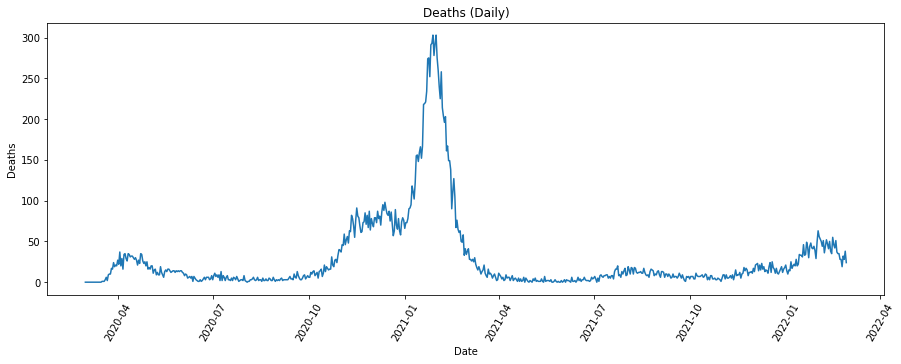

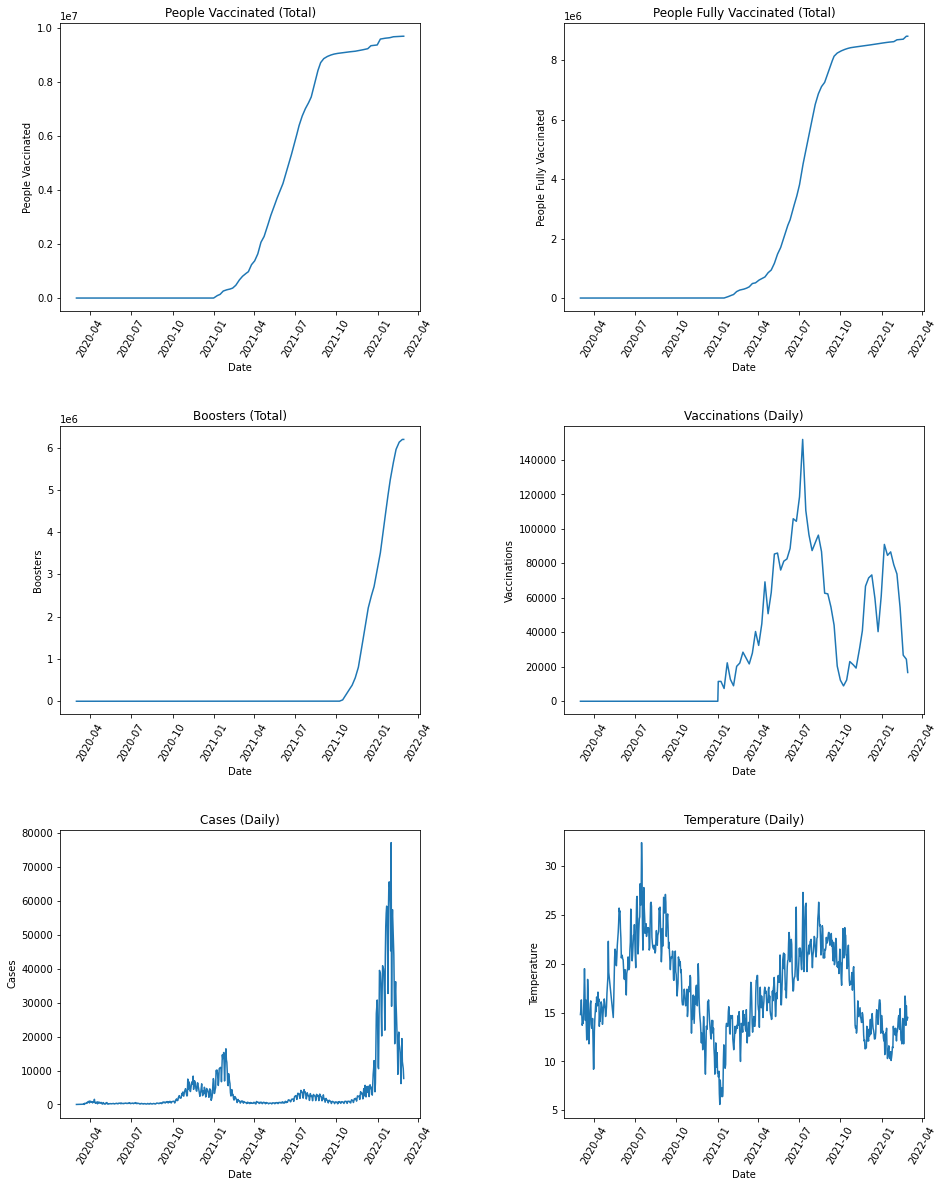

In [12]:
#Plotting Variables
fig, ax1 = plt.subplots(nrows=1, ncols = 1, figsize=(15,5)) 
#Deaths
ax1.plot(covid_data['new_deaths'])
ax1.set_title('Deaths (Daily)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Deaths')

fig, [[ax3,ax4],[ax5,ax6],[ax7,ax8]] = plt.subplots(nrows=3, ncols = 2, figsize=(15,8))  
#Cases
ax7.plot(covid_data['new_cases'])
ax7.set_title('Cases (Daily)')
ax7.set_xlabel('Date')
ax7.set_ylabel('Cases')
#Vaccination
ax3.plot(covid_data['people_vaccinated'])
ax3.set_title('People Vaccinated (Total)')
ax3.set_xlabel('Date')
ax3.set_ylabel('People Vaccinated')
ax4.plot(covid_data['people_fully_vaccinated'])
ax4.set_title('People Fully Vaccinated (Total)')
ax4.set_xlabel('Date')
ax4.set_ylabel('People Fully Vaccinated')
ax5.plot(covid_data['boosters'])
ax5.set_title('Boosters (Total)')
ax5.set_xlabel('Date')
ax5.set_ylabel('Boosters')
ax6.plot(covid_data['new_vaccinations'])
ax6.set_title('Vaccinations (Daily)')
ax6.set_xlabel('Date')
ax6.set_ylabel('Vaccinations')
ax8.plot(temperature['temperature'])
ax8.set_title('Temperature (Daily)')
ax8.set_xlabel('Date')
ax8.set_ylabel('Temperature')

plt.subplots_adjust(left=0.1,
                    bottom=-1.0, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

ax1.tick_params(axis='x', rotation=60)
ax3.tick_params(axis='x', rotation=60)
ax4.tick_params(axis='x', rotation=60)
ax5.tick_params(axis='x', rotation=60)
ax6.tick_params(axis='x', rotation=60)
ax7.tick_params(axis='x', rotation=60)
ax8.tick_params(axis='x', rotation=60)

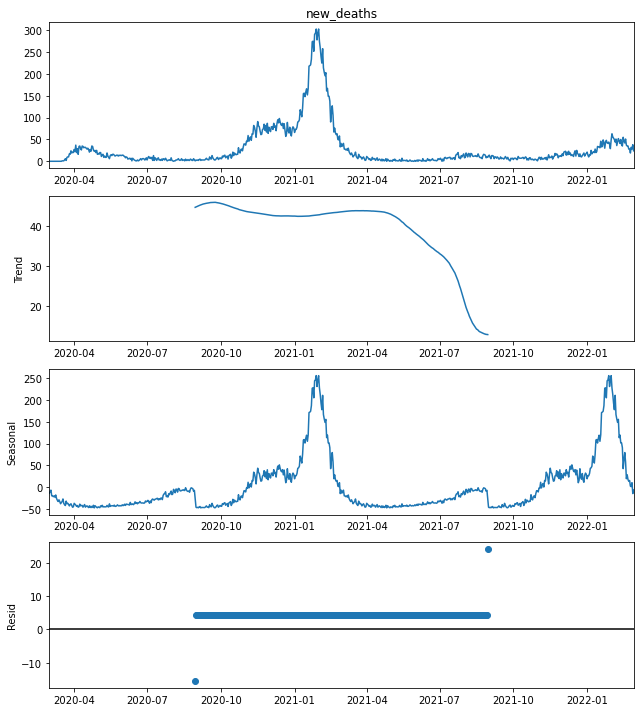

In [13]:
#### Seasonal Decompose ####
series = pd.Series(covid_data['new_deaths'])
result=seasonal_decompose(series, model='additive', period=365)
rcParams['figure.figsize'] = 9,10
figure = result.plot()


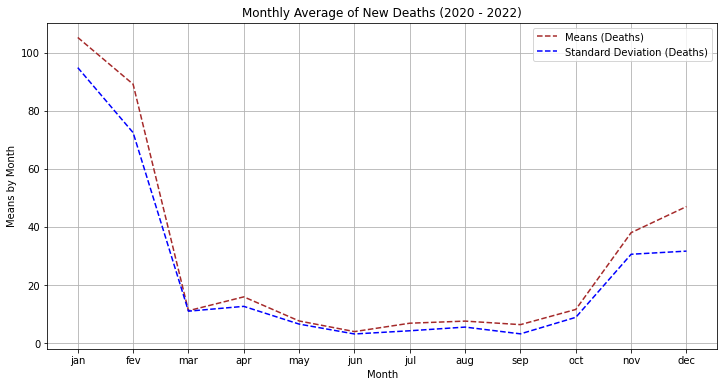

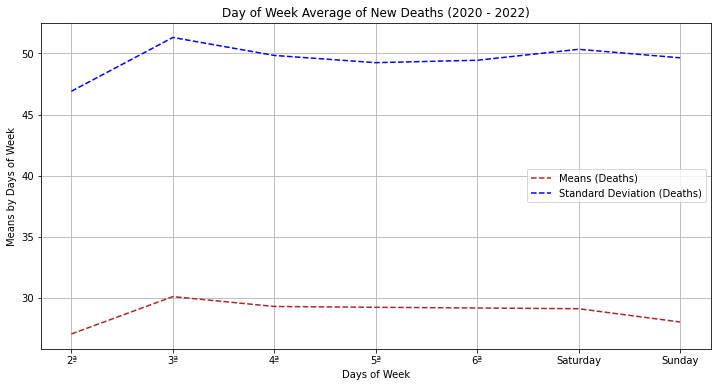

In [14]:
###########  Ploting Means by Month and Days of Week - Deaths  ######################

### Remove weekends from Covid Data
covid_data_means = covid_data.reset_index()
#covid_data_means['Day Of Week']= covid_data_means['Date'].dt.dayofweek
#covid_data_means.drop(covid_data_means.index[covid_data_means['Day Of Week'] == 5], inplace=True)
#covid_data_means.drop(covid_data_means.index[covid_data_means['Day Of Week'] == 6], inplace=True)
covid_data_means.set_index('Date', inplace=True)
covid_data_means.index = pd.to_datetime(covid_data_means.index)
#covid_data_means = covid_data_means.drop(columns=['Day Of Week'])

### Data for plots
monthly_means = (covid_data_means.groupby([covid_data_means.index.month])
           .mean()
           .rename_axis(index=['month'],)
           .reset_index())
monthly_means_std = (covid_data_means.groupby([covid_data_means.index.month])
           .std()
           .rename_axis(index=['month'],)
           .reset_index())

day_of_week_means = (covid_data_means.groupby([covid_data_means.index.weekday])
           .mean()
           .rename_axis(index=['weekday'],)
           .reset_index())
day_of_week_means_std = (covid_data_means.groupby([covid_data_means.index.weekday])
           .std()
           .rename_axis(index=['weekday'],)
           .reset_index())
#day_of_week_means['dayofweek'] = ('2ª','3ª','4ª','5ª','6ª')
day_of_week_means['dayofweek'] = ('2ª','3ª','4ª','5ª','6ª','Saturday','Sunday')
day_of_week_means_std['dayofweek'] = ('2ª','3ª','4ª','5ª','6ª','Saturday','Sunday')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(monthly_means['month'], monthly_means['new_deaths'], color='brown', linestyle='--', label='Means (Deaths)')
ax.plot(monthly_means_std['month'], monthly_means_std['new_deaths'], color='blue', linestyle='--', label='Standard Deviation (Deaths)')
ax.set_title('Monthly Average of New Deaths (2020 - 2022)')
ax.set_ylabel('Means by Month')
ax.set_xlabel('Month')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['jan','fev','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
ax.legend()
ax.grid()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(day_of_week_means['dayofweek'], day_of_week_means['new_deaths'], color='brown', linestyle='--', label='Means (Deaths)')
ax.plot(day_of_week_means_std['dayofweek'], day_of_week_means_std['new_deaths'], color='blue', linestyle='--', label='Standard Deviation (Deaths)')
ax.set_title('Day of Week Average of New Deaths (2020 - 2022)')
ax.set_ylabel('Means by Days of Week')
ax.set_xlabel('Days of Week')
ax.legend()
ax.grid()

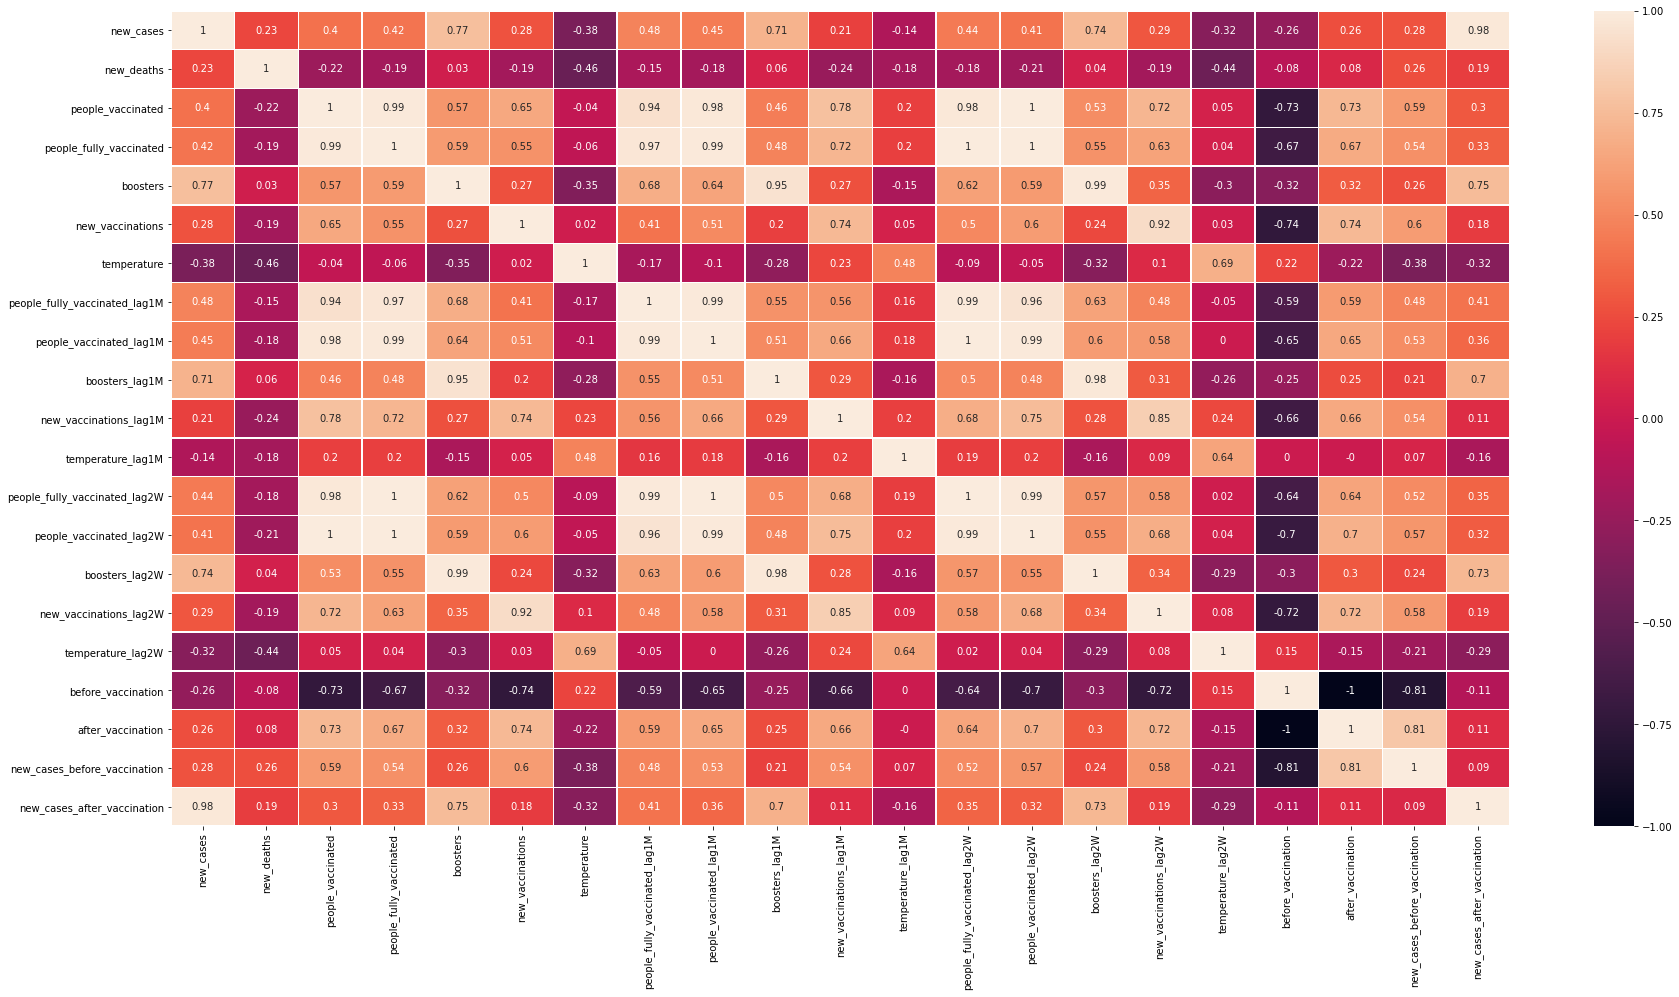

In [8]:
############# Data Correlation ###############

correlation = data.corr()
correlation= correlation.fillna(0)
correlation = round(correlation,2)

fig, ax = plt.subplots(figsize=(30,15))       
plot_corr=sns.heatmap(correlation, annot=True, linewidths=.5, ax=ax)



In [ ]:
############ Starting OLS Model ##############
##### Add temperature ########
y_ols = data['new_deaths']
x_ols = data[['temperature']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

######## VIF OK

In [ ]:
############ Starting OLS Model ##############
##### Add new_cases_before_vaccination ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

######## VIF OK

In [ ]:
############ Starting OLS Model ##############
##### Add new_vaccinations_lag1M ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

######## VIF OK

In [ ]:
############ Starting OLS Model ##############
##### Add new_cases ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','new_cases']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

########VIF OK

In [ ]:
############ Starting OLS Model ##############
##### Add people_vaccinated ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','new_cases','people_vaccinated']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

#VIF OK

In [ ]:
############ Starting OLS Model ##############
##### Add new_vaccinations ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','new_cases','people_vaccinated','new_vaccinations']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

# VIF OK

In [ ]:
############ Starting OLS Model ##############
##### Add people_vaccinated_lag2W ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','new_cases','people_vaccinated','new_vaccinations','people_vaccinated_lag2W']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

# VIF NOT OK (REMOVE LESS CORRELATION VARIABLE (people_vaccinated_lag2W))

In [ ]:
############ Starting OLS Model ##############
##### Add new_vaccinations_lag2W ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','new_cases','people_vaccinated','new_vaccinations','new_vaccinations_lag2W']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

# VIF NOT OK (REMOVE LESS CORRELATION VARIABLE (new_vaccinations_lag2W))  #The are 2 equal 'New_Vaccinations' and 'New_Vaccinations_Lag2W' so the highest VIF were removed

In [ ]:
############ Starting OLS Model ##############
##### Add 'people_fully_vaccinated' ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','new_cases','people_vaccinated','new_vaccinations','people_fully_vaccinated']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

# VIF NOT OK (REMOVE LESS CORRELATION VARIABLE ('people_fully_vaccinated'))

In [ ]:
############ Starting OLS Model ##############
##### Add 'new_cases_after_vaccination' ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','new_cases','people_vaccinated','new_vaccinations','new_cases_after_vaccination']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

# VIF NOT OK . REMOVE ('new_cases') to study the impact o new_cases before and after vaccination


In [ ]:
############ Starting OLS Model ##############
##### Add 'people_vaccinated_lag1M' ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','people_vaccinated','new_vaccinations','new_cases_after_vaccination','people_vaccinated_lag1M']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

# VIF NOT OK (REMOVE LESS CORRELATION VARIABLE ('people_vaccinated_lag1M'))

In [ ]:
############ Starting OLS Model ##############
##### Add 'people_fully_vaccinated_lag2W' ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','people_vaccinated','new_vaccinations','new_cases_after_vaccination','people_fully_vaccinated_lag2W']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

# VIF NOT OK (REMOVE LESS CORRELATION VARIABLE ('people_fully_vaccinated_lag2W'))

In [ ]:
############ Starting OLS Model ##############
##### Add 'people_fully_vaccinated_lag1M' ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','people_vaccinated','new_vaccinations','new_cases_after_vaccination','people_fully_vaccinated_lag1M']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

# VIF NOT OK (REMOVE LESS CORRELATION VARIABLE ('people_fully_vaccinated_lag1M'))

In [ ]:
############ Starting OLS Model ##############
##### Add 'boosters_lag_1M' ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','people_vaccinated','new_vaccinations','new_cases_after_vaccination','boosters_lag1M']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

######### VIF OK

In [ ]:
############ Starting OLS Model ##############
##### Add 'boosters_lag_2W' ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','people_vaccinated','new_vaccinations','new_cases_after_vaccination','boosters_lag1M','boosters_lag2W']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

# VIF NOT OK (REMOVE LESS CORRELATION VARIABLE ('boosters_lag_2W' ))  #The are 2 equal 'boosters_lag_2W'  and 'boosters_lag_1M'  so the highest VIF were removed

In [ ]:
############ Starting OLS Model ##############
##### Add 'boosters' ########
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','people_vaccinated','new_vaccinations','new_cases_after_vaccination','boosters_lag1M','boosters']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# VIF
x_temp = sm.add_constant(X_train_ols)

vif_data = pd.DataFrame()
vif_data["feature"] = x_temp.columns
vif_data["VIF"] = [variance_inflation_factor(x_temp.values, i)
                          for i in range(len(x_temp.columns))]
  
print(vif_data)

# VIF NOT OK (REMOVE LESS CORRELATION VARIABLE ('boosters'))

In [ ]:
############ OLS Model AFTER VIF CHOICE ##############
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','people_vaccinated','new_vaccinations','new_cases_after_vaccination','boosters_lag1M']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# Prediction 
Y_test_pred_ols = model_ols.predict(sm.add_constant(X_test_ols))


# Plot Y predict vs Y real
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_ols, 'o', label="Real Data")
ax.plot(Y_test_pred_ols, 'o', label="OLS Regression")
ax.legend(loc="best")
ax.set_title('OLS Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')

# Adj R2 Score
r2 = skl.r2_score(Y_test_ols, Y_test_pred_ols)
adj_r2 = 1 - (1-r2) * (len(y_ols)-1)/(len(y_ols)-x_ols.shape[1]-1)
print("\n\033[1mAdj R2 Score after removing not significant variables\033[0m")
print("R2 Score:" , adj_r2)

In [ ]:
############ OLS Model REMOVING NOT SIGNIFICANT VARIABLES (5%) ##############
## REMOVE new_vaccinations_lag1M
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','people_vaccinated','new_vaccinations','new_cases_after_vaccination','boosters_lag1M']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# Prediction 
Y_test_pred_ols = model_ols.predict(sm.add_constant(X_test_ols))


# Plot Y predict vs Y real
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_ols, 'o', label="Real Data")
ax.plot(Y_test_pred_ols, 'o', label="OLS Regression")
ax.legend(loc="best")
ax.set_title('OLS Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')

# Adj R2 Score
r2 = skl.r2_score(Y_test_ols, Y_test_pred_ols)
adj_r2 = 1 - (1-r2) * (len(y_ols)-1)/(len(y_ols)-x_ols.shape[1]-1)
print("\n\033[1mAdj R2 Score after removing not significant variables\033[0m")
print("R2 Score:" , adj_r2)

### Don't Remove Adj R2 decreases

In [ ]:
############ OLS Model REMOVING NOT SIGNIFICANT VARIABLES (5%) ##############
## REMOVE boosters_lag1M
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations','people_vaccinated', 'new_vaccinations_lag1M','new_cases_after_vaccination']]
X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(model_ols.summary())
model = LinearRegression()
# fit the model
model.fit(X_train_ols, Y_train_ols)

# Prediction 
Y_test_pred_ols = model_ols.predict(sm.add_constant(X_test_ols))


# Plot Y predict vs Y real
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_ols, 'o', label="Real Data")
ax.plot(Y_test_pred_ols, 'o', label="OLS Regression")
ax.legend(loc="best")
ax.set_title('OLS Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')

# Adj R2 Score
r2 = skl.r2_score(Y_test_ols, Y_test_pred_ols)
adj_r2 = 1 - (1-r2) * (len(y_ols)-1)/(len(y_ols)-x_ols.shape[1]-1)
print("\n\033[1mAdj R2 Score after removing not significant variables\033[0m")
print("R2 Score:" , adj_r2)

### Don't Remove Adj R2 decreases

      
OLS Model
                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     47.45
Date:                Fri, 29 Jul 2022   Prob (F-statistic):           7.60e-49
Time:                        23:20:58   Log-Likelihood:                -466.22
No. Observations:                 408   AIC:                             948.4
Df Residuals:                     400   BIC:                             980.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

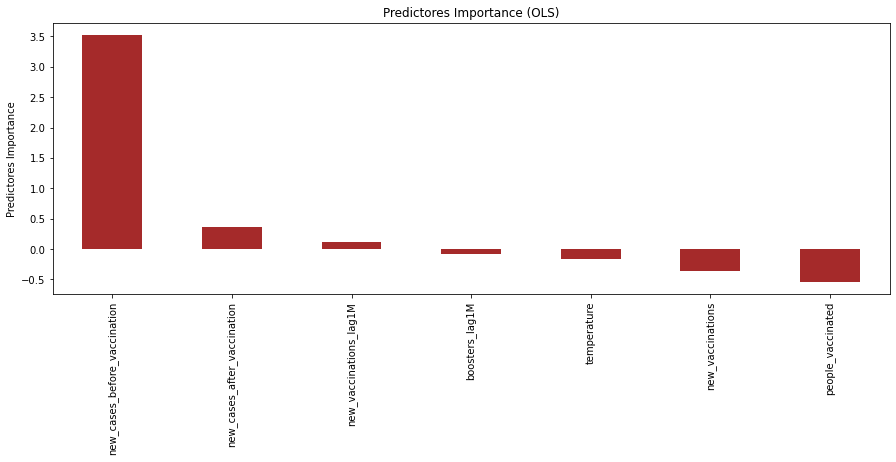

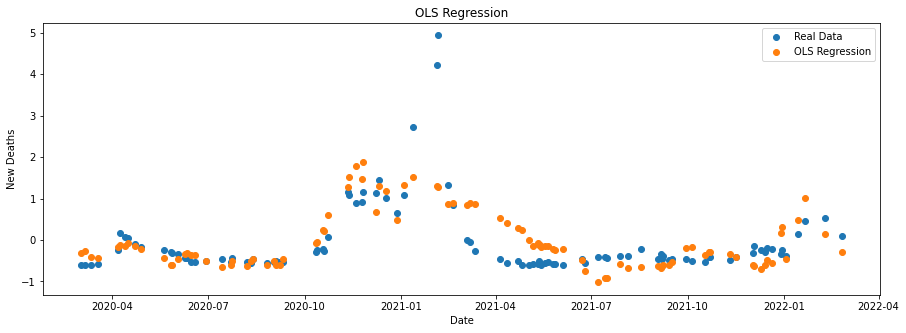

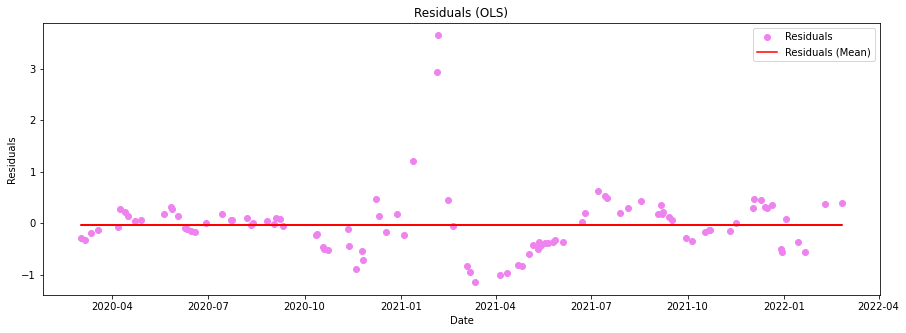

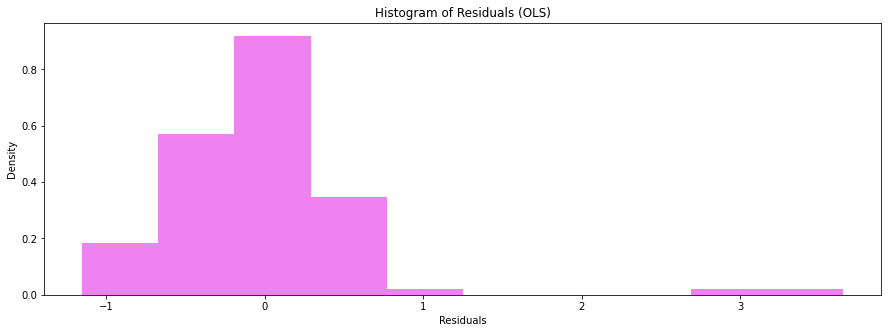

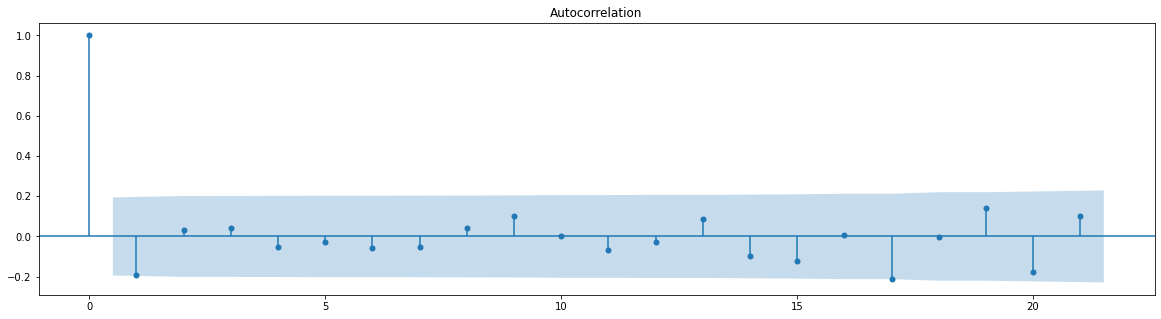

In [6]:
############ OLS FINAL Model ##############
y_ols = data['new_deaths']
x_ols = data[['temperature','new_cases_before_vaccination','new_vaccinations_lag1M','people_vaccinated','new_vaccinations','new_cases_after_vaccination','boosters_lag1M']]

X_train_ols, X_test_ols, Y_train_ols, Y_test_ols = sklearn.model_selection.train_test_split(x_ols, y_ols, test_size = 0.20,random_state=8) #Random para não existir overfitting

# Model
model_ols = sm.OLS(Y_train_ols, sm.add_constant(X_train_ols)).fit()
print(" "* 5,"\n\033[1mOLS Model\033[0m")
print(model_ols.summary())

# Prediction 
Y_test_pred_ols = model_ols.predict(sm.add_constant(X_test_ols))
predictors_ols=list(X_train_ols)
fig, ax = plt.subplots(figsize=(15,5))
pred_importance_ols= pd.Series(model_ols.params, predictors_ols).sort_values(ascending=False)
pred_importance_ols.plot.bar( color = 'brown')
plt.ylabel('Predictores Importance')
plt.title('Predictores Importance (OLS)')

# Plot Y predict vs Y real
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_ols, 'o', label="Real Data")
ax.plot(Y_test_pred_ols, 'o', label="OLS Regression")
ax.legend(loc="best")
ax.set_title('OLS Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')

#Residuals
residuals_ols_df = pd.DataFrame(Y_test_ols.values - Y_test_pred_ols.values)
residuals_ols_df.rename(columns = {0:'Residuals'}, inplace = True)
residuals_ols_df.index = Y_test_ols.index
residuals_ols_df = residuals_ols_df.reset_index()
residuals_ols_df['mean'] = residuals_ols_df['Residuals'].mean()
print(residuals_ols_df)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(residuals_ols_df['Date'],residuals_ols_df['Residuals'], 'o', color = 'violet', label = 'Residuals')
ax.plot(residuals_ols_df['Date'],residuals_ols_df['mean'],color = 'red', label ='Residuals (Mean)') 
ax.legend(loc="best")
ax.set_title('Residuals (OLS)')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
fig,ax = plt.subplots(figsize=(15,5))
ax.hist(residuals_ols_df['Residuals'],color = 'violet',density = True)
ax.set_title('Histogram of Residuals (OLS)')
ax.set_xlabel('Residuals')
ax.set_ylabel('Density')

# ACF of Residuals
plt.figure(figsize=(20,5))
acf =plot_acf(residuals_ols_df['Residuals'], ax=plt.gca())

print("-"*120)
print("\n\033[1mDurbin-Watson Test for Residuals:\033[0m",durbin_watson(Y_test_ols.values - Y_test_pred_ols.values))


In [ ]:
############################# Ridge Model - Final Model #############################
y_Ridge = y_ols
x_Ridge = x_ols

X_train_Ridge, X_test_Ridge, Y_train_Ridge, Y_test_Ridge = sklearn.model_selection.train_test_split(x_Ridge, y_Ridge, test_size = 0.20,random_state=8)


#Optimal Alpha
alphas_Ridge = np.linspace(0.01,1000,1000)
model_alpha_Ridge = Ridge(max_iter=10000)
coefs_alpha_Ridge = []

for i in alphas_Ridge:
    model_alpha_Ridge.set_params(alpha=i)
    model_alpha_Ridge.fit(X_train_Ridge, Y_train_Ridge)
    coefs_alpha_Ridge.append(model_alpha_Ridge.coef_)

fig,ax = plt.subplots(figsize=(15,5))
line1,line2,line3,line4,line5,line6,line7=ax.plot(alphas_Ridge,coefs_alpha_Ridge)
line1.set_label('temperature')
line2.set_label('new_cases_before_vaccination')
line3.set_label('new_vaccinations_lag1M')
line4.set_label('people_vaccinated')
line5.set_label('new_vaccinations')
line6.set_label('new_cases_after_vaccination')
line7.set_label('boosters_lag1M')
ax.set_xscale('log')
ax.set_title('Ridge coefficients per alpha')
ax.set_xlabel('alpha')
ax.set_ylabel('Coefficients')
ax.legend(loc='best')

model_alpha_Ridge = RidgeCV(cv=5, alphas = alphas_Ridge)
model_alpha_Ridge.fit(X_train_Ridge, Y_train_Ridge)
opt_alpha_Ridge = model_alpha_Ridge.alpha_
print("\n\033[1mOptimal Alpha (Ridge):\033[0m", opt_alpha_Ridge)
print("-"*120)
print("-"*120)

# Model
model_Ridge = Ridge(alpha = opt_alpha_Ridge)
model_Ridge_fit = model_Ridge.fit(X_train_Ridge,Y_train_Ridge)
coefs_Ridge = []
coefs_Ridge.append(model_Ridge.coef_)
coefs_Ridge_df = pd.DataFrame(coefs_Ridge)
coefs_Ridge_df.rename(columns = {0:'temperature',1:'new_cases_before_vaccination',2:'new_vaccinations_lag1M',3:'people_vaccinated',4:'new_vaccinations',5:'new_cases_after_vaccination',6:'boosters_lag1M'}, inplace = True)
coefs_Ridge_df['Coefficients'] = 'Coefficients'
coefs_Ridge_df.set_index('Coefficients', inplace = True)
coefs_Ridge_df = coefs_Ridge_df.style.set_properties(**{'text-align': 'center'})
print(" "* 5,"\n\033[1mRidge Model\033[0m")
with pd.option_context('expand_frame_repr', False):
    display(coefs_Ridge_df)
    print("-"*120)
    


# Prediction 
Y_test_pred_Ridge = model_Ridge.predict(X_test_Ridge)
Y_test_pred_Ridge = pd.DataFrame(Y_test_pred_Ridge)
Y_test_pred_Ridge.rename(columns = {0: 'Ridge Regression'}, inplace = True)
Y_test_Ridge = Y_test_Ridge.reset_index()
Y_test_pred_Ridge['Date'] = Y_test_Ridge['Date']
Y_test_pred_Ridge.set_index('Date', inplace=True)
Y_test_Ridge.set_index('Date', inplace=True)

predictors_Ridge=list(X_train_Ridge)
fig, ax = plt.subplots(figsize=(15,5))
pred_importance_Ridge= pd.Series(model_Ridge.coef_, predictors_Ridge).sort_values(ascending=False)
pred_importance_Ridge.plot.bar( color = 'brown')
plt.ylabel('Predictores Importance')
plt.title('Predictores Importance (Ridge)')



# Plot Y predict vs Y real
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_Ridge, 'o', label="Real Data")
ax.plot(Y_test_pred_Ridge, 'o', label="Ridge Regression")
ax.legend(loc="best")
ax.set_title('Ridge Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')

#Residuals
residuals_Ridge_df = pd.DataFrame(Y_test_Ridge.values - Y_test_pred_Ridge.values,columns=Y_test_Ridge.columns)
residuals_Ridge_df.rename(columns = {'new_deaths':'Residuals'}, inplace = True)
residuals_Ridge_df.index = Y_test_Ridge.index
residuals_Ridge_df = residuals_Ridge_df.reset_index()
residuals_Ridge_df['mean'] = residuals_Ridge_df['Residuals'].mean()
print(residuals_Ridge_df)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(residuals_Ridge_df['Date'],residuals_Ridge_df['Residuals'], 'o', color = 'violet', label = 'Residuals')
ax.plot(residuals_Ridge_df['Date'],residuals_Ridge_df['mean'],color = 'red', label ='Residuals (Mean)') 
ax.legend(loc="best")
ax.set_title('Residuals (Ridge)')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
fig,ax = plt.subplots(figsize=(15,5))
ax.hist(residuals_Ridge_df['Residuals'],color = 'violet',density = True)
ax.set_title('Histogram of Residuals (Ridge)')
ax.set_xlabel('Residuals')
ax.set_ylabel('Density')

# ACF of Residuals
plt.figure(figsize=(20,5))
acf =plot_acf(residuals_Ridge_df['Residuals'], ax=plt.gca())

print("\n\033[1mDurbin-Watson Test for Residuals:\033[0m",durbin_watson(Y_test_Ridge.values - Y_test_pred_Ridge.values))


In [ ]:
############ Lasso Model - Final Model #################

y_Lasso = y_ols
x_Lasso = x_ols

X_train_Lasso, X_test_Lasso, Y_train_Lasso, Y_test_Lasso = sklearn.model_selection.train_test_split(x_Lasso, y_Lasso, test_size = 0.20,random_state=8)

#Optimal Alpha
alphas_Lasso = np.linspace(0.01,10,100)
model_alpha_Lasso = Lasso(max_iter=10000)
coefs_alpha_Lasso = []

for i in alphas_Lasso:
    model_alpha_Lasso.set_params(alpha=i)
    model_alpha_Lasso.fit(X_train_Lasso, Y_train_Lasso)
    coefs_alpha_Lasso.append(model_alpha_Lasso.coef_)

fig,ax = plt.subplots(figsize=(15,5))
line1,line2,line3,line4,line5,line6,line7=ax.plot(alphas_Lasso,coefs_alpha_Lasso)
line1.set_label('temperature')
line2.set_label('new_cases_before_vaccination')
line3.set_label('new_vaccinations_lag1M')
line4.set_label('people_vaccinated')
line5.set_label('new_vaccinations')
line6.set_label('new_cases_after_vaccination')
line7.set_label('boosters_lag1M')
ax.set_xscale('log')
ax.set_title('Lasso coefficients per alpha')
ax.set_xlabel('alpha')
ax.set_ylabel('Coefficients')
ax.legend(loc='best')


model_alpha_Lasso = LassoCV(cv=5, random_state=8, max_iter=10000)
model_alpha_Lasso.fit(X_train_Lasso, Y_train_Lasso)
opt_alpha_Lasso = model_alpha_Lasso.alpha_
print("\n\033[1mOptimal Alpha (Lasso):\033[0m", opt_alpha_Lasso)
print("-"*120)
print("-"*120)

# Model
model_Lasso = Lasso(alpha = opt_alpha_Lasso)
model_Lasso_fit = model_Lasso.fit(X_train_Lasso,Y_train_Lasso)
coefs_Lasso = []
coefs_Lasso.append(model_Lasso.coef_)
coefs_Lasso_df = pd.DataFrame(coefs_Lasso)
coefs_Lasso_df.rename(columns = {0:'temperature',1:'new_cases_before_vaccination',2:'new_vaccinations_lag1M',3:'people_vaccinated',4:'new_vaccinations',5:'new_cases_after_vaccination',6:'boosters_lag1M'}, inplace = True)
coefs_Lasso_df['Coefficients'] = 'Coefficients'
coefs_Lasso_df.set_index('Coefficients', inplace = True)
coefs_Lasso_df = coefs_Lasso_df.style.set_properties(**{'text-align': 'center'})
print(" "* 5,"\n\033[1mLasso Model\033[0m")
with pd.option_context('expand_frame_repr', False):
    display(coefs_Lasso_df)
    print("-"*120)

# Prediction 
Y_test_pred_Lasso = model_Lasso.predict(X_test_Lasso)
Y_test_pred_Lasso = pd.DataFrame(Y_test_pred_Lasso)
Y_test_pred_Lasso.rename(columns = {0: 'Lasso Regression'}, inplace = True)
Y_test_Lasso = Y_test_Lasso.reset_index()
Y_test_pred_Lasso['Date'] = Y_test_Lasso['Date']
Y_test_pred_Lasso.set_index('Date', inplace=True)
Y_test_Lasso.set_index('Date', inplace=True)

predictors_Lasso=list(X_train_Lasso)
fig, ax = plt.subplots(figsize=(15,5))
pred_importance_Lasso= pd.Series(model_Lasso.coef_, predictors_Lasso).sort_values(ascending=False)
pred_importance_Lasso.plot.bar( color = 'brown')
plt.ylabel('Predictores Importance')
plt.title('Predictores Importance (Lasso)')

# Plot Y predict vs Y real
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_Lasso, 'o', label="Real Data")
ax.plot(Y_test_pred_Lasso, 'o', label="Lasso Regression")
ax.legend(loc="best")
ax.set_title('Lasso Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')

#Residuals
residuals_Lasso_df = pd.DataFrame(Y_test_Lasso.values - Y_test_pred_Lasso.values,columns=Y_test_Lasso.columns)
residuals_Lasso_df.rename(columns = {'new_deaths':'Residuals'}, inplace = True)
residuals_Lasso_df.index = Y_test_Lasso.index
residuals_Lasso_df = residuals_Lasso_df.reset_index()
residuals_Lasso_df['mean'] = residuals_Lasso_df['Residuals'].mean()
print(residuals_Lasso_df)
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(residuals_Lasso_df['Date'],residuals_Lasso_df['Residuals'], 'o', color = 'violet', label = 'Residuals')
ax.plot(residuals_Lasso_df['Date'],residuals_Lasso_df['mean'],color = 'red', label ='Residuals (Mean)') 
ax.legend(loc="best")
ax.set_title('Residuals (Lasso)')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
fig,ax = plt.subplots(figsize=(15,5))
ax.hist(residuals_Lasso_df['Residuals'],color = 'violet',density = True)
ax.set_title('Histogram of Residuals (Lasso)')
ax.set_xlabel('Residuals')
ax.set_ylabel('Density')

# ACF of Residuals
plt.figure(figsize=(20,5))
acf =plot_acf(residuals_Lasso_df['Residuals'], ax=plt.gca())

print("\n\033[1mDurbin-Watson Test for Residuals:\033[0m",durbin_watson(Y_test_Lasso.values - Y_test_pred_Lasso.values))


In [7]:
############## Gradient Boosting - Optimize Parameters ##############

y_GB = y_ols
x_GB  = x_ols

X_train_GB , X_test_GB , Y_train_GB , Y_test_GB  = sklearn.model_selection.train_test_split(x_GB , y_GB , test_size = 0.20,random_state=8)

#### Optimizing Paramaters

optimize = {'learning_rate': uniform(0.001,0.1),'subsample': uniform(0.1,0.9), 'n_estimators' : randint(100, 1000),'max_depth': randint(2, 10),'min_samples_split':randint(2, 10),'min_samples_leaf': randint(5,15),'max_features':randint(2,10)}

optimize_GB = RandomizedSearchCV(estimator =GradientBoostingRegressor(), param_distributions = optimize,n_jobs=-1, cv=5, n_iter = 100, random_state = 8)
optimize_GB.fit(X_train_GB,Y_train_GB)


best_params_GB = pd.DataFrame(optimize_GB.best_params_.items())
best_params_GB= best_params_GB.rename(columns={0: 'Predictors',1:'Best Values'}) 
best_score_GB_list = []
best_score_GB_list.append(optimize_GB.best_score_)
best_score_GB = pd.DataFrame(best_score_GB_list)
best_score_GB= best_score_GB.rename(columns={0: 'Best Score'})

display(best_params_GB.style.hide_index())
display(best_score_GB.style.hide_index())

learning_rate_opt = best_params_GB.loc[best_params_GB['Predictors'] == 'learning_rate', 'Best Values'].item()
max_depth_opt = best_params_GB.loc[best_params_GB['Predictors'] == 'max_depth', 'Best Values'].item()
max_features_opt = best_params_GB.loc[best_params_GB['Predictors'] == 'max_features', 'Best Values'].item()
min_samples_leaf_opt = best_params_GB.loc[best_params_GB['Predictors'] == 'min_samples_leaf', 'Best Values'].item()
min_samples_split_opt = best_params_GB.loc[best_params_GB['Predictors'] == 'min_samples_split', 'Best Values'].item()
n_estimators_opt = best_params_GB.loc[best_params_GB['Predictors'] == 'n_estimators', 'Best Values'].item()
subsample_opt = best_params_GB.loc[best_params_GB['Predictors'] == 'subsample', 'Best Values'].item()

max_depth_opt = int(max_depth_opt)
max_features_opt = int(max_features_opt)
min_samples_leaf_opt = int(min_samples_leaf_opt)
min_samples_split_opt = int(min_samples_split_opt)
n_estimators_opt = int(n_estimators_opt)

print("\n\033[1mBest Estimator:\033[0m\n", optimize_GB.best_estimator_)



Predictors,Best Values
learning_rate,0.034243
max_depth,4.000000
max_features,5.000000
min_samples_leaf,5.000000
min_samples_split,2.000000
n_estimators,517.000000
subsample,0.827372


Best Score
0.934390



Best Estimator:
 GradientBoostingRegressor(learning_rate=0.03424254963605016, max_depth=4,
                          max_features=5, min_samples_leaf=5, n_estimators=517,
                          subsample=0.8273721628555785)


      
Gradient Boosting Model (Optimized)


,Coefficients
Predictors,
people_vaccinated,0.334390
temperature,0.195581
new_cases_after_vaccination,0.136848
new_vaccinations,0.109508
new_cases_before_vaccination,0.078527
boosters_lag1M,0.075357
new_vaccinations_lag1M,0.069789


------------------------------------------------------------------------------------------------------------------------
          Date  Residuals      mean
0   2021-09-13  -0.030360  0.009917
1   2020-04-13   0.187658  0.009917
2   2020-08-11   0.013159  0.009917
3   2020-08-07  -0.003916  0.009917
4   2021-11-10  -0.135388  0.009917
..         ...        ...       ...
97  2020-04-22  -0.001422  0.009917
98  2020-06-19  -0.135654  0.009917
99  2020-08-13   0.044048  0.009917
100 2021-07-14   0.007304  0.009917
101 2021-09-07  -0.044711  0.009917

[102 rows x 3 columns]


------------------------------------------------------------------------------------------------------------------------

Durbin-Watson Test for Residuals: [2.14923454]


------------------------------------------------------------------------------------------------------------------------

MAE - Optimized
MAE: 0.12269679656557063

MSE - Optimized
MSE: 0.04709432820675203

Median Absolute Error - Optimized
Median Abs

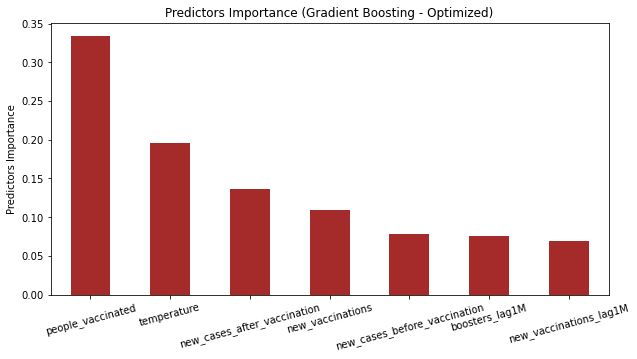

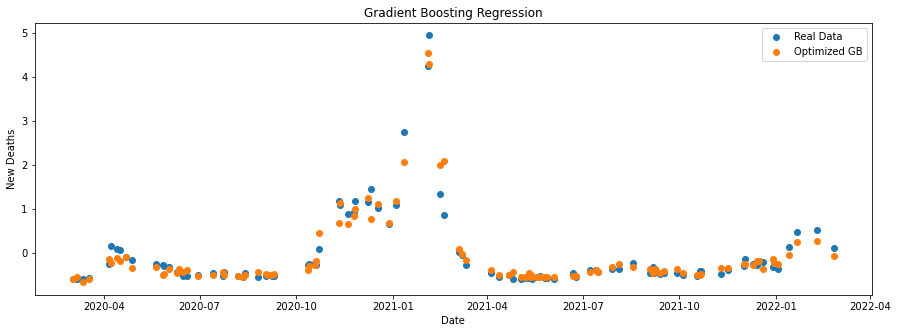

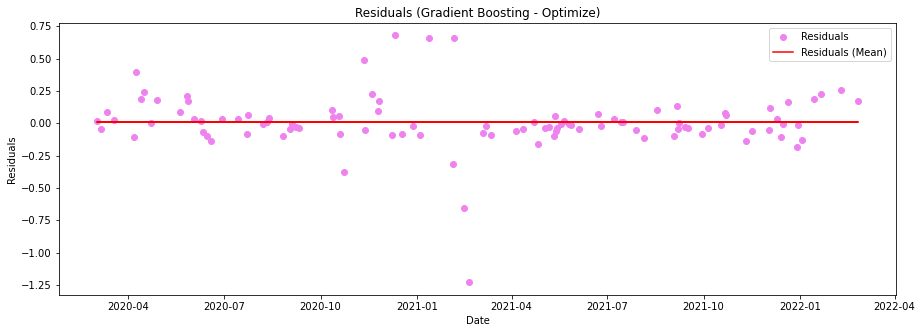

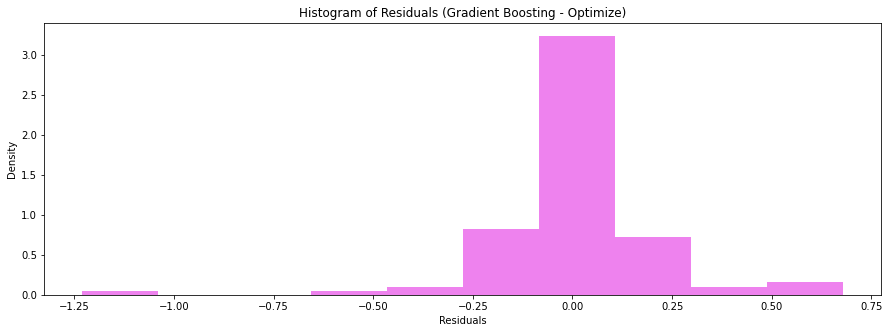

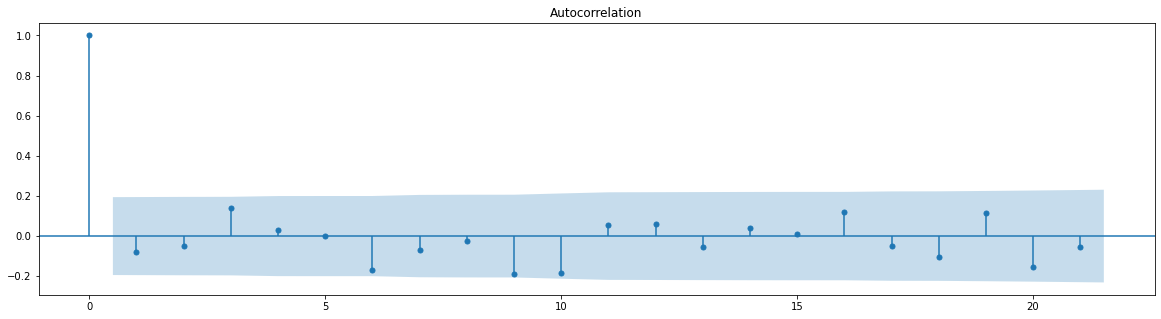

In [16]:
#################### Gradient Boosting - Final Model ###################

y_GB = y_ols
x_GB  = x_ols

X_train_GB , X_test_GB , Y_train_GB , Y_test_GB  = sklearn.model_selection.train_test_split(x_GB , y_GB , test_size = 0.20,random_state=8)

#Fit Model
optimize_GB = GradientBoostingRegressor(learning_rate=learning_rate_opt, n_estimators=n_estimators_opt,max_depth=max_depth_opt, min_samples_split=min_samples_split_opt, min_samples_leaf=min_samples_leaf_opt, subsample=subsample_opt,max_features=max_features_opt, random_state = 8)
optimize_GB.fit(X_train_GB,Y_train_GB)

# Predict
predictors_GB=list(X_train_GB)
fig, ax = plt.subplots(figsize=(10,5))
pred_importance= pd.Series(optimize_GB.feature_importances_, predictors_GB).sort_values(ascending=False)
pred_importance.plot.bar( color = 'brown')
plt.ylabel('Predictors Importance')
plt.title('Predictors Importance (Gradient Boosting - Optimized)')
ax.tick_params(axis='x', rotation=15)
optimize_GB_pred=optimize_GB.predict(X_test_GB)
optimize_GB_pred = pd.DataFrame(optimize_GB_pred)
coefs_optimize_GB_df = pd.DataFrame(optimize_GB.feature_importances_)
coefs_optimize_GB_df.rename(columns = {0:'Coefficients'}, inplace = True)
coefs_optimize_GB_df['Predictors'] = predictors_GB
coefs_optimize_GB_df.set_index('Predictors', inplace = True)
coefs_optimize_GB_df = coefs_optimize_GB_df.sort_values(by=['Coefficients'], ascending = False)
print(" "* 5,"\n\033[1mGradient Boosting Model (Optimized)\033[0m")
with pd.option_context('expand_frame_repr', False):
    display(coefs_optimize_GB_df)
    print("-"*120)

#Plotting
optimize_GB_pred.rename(columns = {0: 'Gradient Boosting Optimized'}, inplace = True)
Y_test_GB = Y_test_GB.reset_index()
optimize_GB_pred['Date'] = Y_test_GB['Date']
optimize_GB_pred.set_index('Date', inplace=True)
Y_test_GB.set_index('Date', inplace=True)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_GB, 'o', label="Real Data")
ax.plot(optimize_GB_pred, 'o', label="Optimized GB")
ax.legend(loc="best")
ax.set_title('Gradient Boosting Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')

###Residuals
residuals_optimize_GB_df = pd.DataFrame(Y_test_GB.values - optimize_GB_pred.values,columns=Y_test_GB.columns)
residuals_optimize_GB_df.rename(columns = {'new_deaths':'Residuals'}, inplace = True)
residuals_optimize_GB_df.index = Y_test_GB.index
residuals_optimize_GB_df = residuals_optimize_GB_df.reset_index()
residuals_optimize_GB_df['mean'] = residuals_optimize_GB_df['Residuals'].mean()
print(residuals_optimize_GB_df)
# Plotting
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(residuals_optimize_GB_df['Date'],residuals_optimize_GB_df['Residuals'], 'o', color = 'violet', label = 'Residuals')
ax.plot(residuals_optimize_GB_df['Date'],residuals_optimize_GB_df['mean'],color = 'red', label ='Residuals (Mean)')  
ax.legend(loc="best")
ax.set_title('Residuals (Gradient Boosting - Optimize)')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
fig,ax = plt.subplots(figsize=(15,5))
ax.hist(residuals_optimize_GB_df['Residuals'],color = 'violet',density = True)
ax.set_title('Histogram of Residuals (Gradient Boosting - Optimize)')
ax.set_xlabel('Residuals')
ax.set_ylabel('Density')

# ACF of Residuals
plt.figure(figsize=(20,5))
acf =plot_acf(residuals_optimize_GB_df['Residuals'], ax=plt.gca())

print("\n")
print("-"*120)

print("\n\033[1mDurbin-Watson Test for Residuals:\033[0m",durbin_watson(Y_test_GB.values - optimize_GB_pred.values))


In [36]:
############## MLP Regressor - Optimize Parameters ##############

y_MLP = y_ols
x_MLP  = x_ols

X_train_MLP , X_test_MLP , Y_train_MLP , Y_test_MLP  = sklearn.model_selection.train_test_split(x_MLP , y_MLP , test_size = 0.20,random_state=8)

#### Optimizing Paramaters

optimize = {'hidden_layer_sizes': tuple(np.random.randint(1,100,size=3)),'activation': ['relu','tanh','logistic'], 'alpha' : uniform(0.0001,0.1),'solver': ['lbfgs', 'sgd', 'adam']}

optimize_MLP = RandomizedSearchCV(estimator =MLPRegressor(), param_distributions = optimize,n_jobs=-1, cv=5, n_iter = 100,random_state = 8)
optimize_MLP.fit(X_train_MLP,Y_train_MLP)

best_params_MLP = pd.DataFrame(optimize_MLP.best_params_.items())
best_params_MLP= best_params_MLP.rename(columns={0: 'Predictors',1:'Best Values'}) 
best_score_MLP_list = []
best_score_MLP_list.append(optimize_MLP.best_score_)
best_score_MLP = pd.DataFrame(best_score_MLP_list)
best_score_MLP= best_score_MLP.rename(columns={0: 'Best Score'})

display(best_params_MLP.style.hide_index())
display(best_score_MLP.style.hide_index())

hidden_layer_sizes = best_params_MLP.loc[best_params_MLP['Predictors'] == 'hidden_layer_sizes', 'Best Values'].item()
activation = best_params_MLP.loc[best_params_MLP['Predictors'] == 'activation', 'Best Values'].item()
alpha = best_params_MLP.loc[best_params_MLP['Predictors'] == 'alpha', 'Best Values'].item()
solver = best_params_MLP.loc[best_params_MLP['Predictors'] == 'solver', 'Best Values'].item()


hidden_layer_sizes = int(hidden_layer_sizes)


print("\n\033[1mBest Estimator:\033[0m\n", optimize_MLP.best_estimator_)

C:\Users\Alexandre Arriaga\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Predictors,Best Values
activation,tanh
alpha,0.043058
hidden_layer_sizes,22
solver,lbfgs


Best Score
0.929978



Best Estimator:
 MLPRegressor(activation='tanh', alpha=0.04305779261041452,
             hidden_layer_sizes=22, solver='lbfgs')


C:\Users\Alexandre Arriaga\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


          Date  Residuals      mean
0   2021-09-13  -0.077869  0.001185
1   2020-04-13   0.259015  0.001185
2   2020-08-11  -0.092750  0.001185
3   2020-08-07  -0.034652  0.001185
4   2021-11-10  -0.054957  0.001185
..         ...        ...       ...
97  2020-04-22   0.109744  0.001185
98  2020-06-19  -0.093832  0.001185
99  2020-08-13   0.014496  0.001185
100 2021-07-14   0.045757  0.001185
101 2021-09-07  -0.091741  0.001185

[102 rows x 3 columns]


------------------------------------------------------------------------------------------------------------------------

Durbin-Watson Test for Residuals: [2.25986745]


------------------------------------------------------------------------------------------------------------------------

MAE - Optimized
MAE: 0.18972429886323183

MSE - Optimized
MSE: 0.13331741405402484

Median Absolute Error - Optimized
Median Absolute Error: 0.0864926269912713

Explained Variance Score - Optimized
Explained Variance Score: 0.8290954672441295

R2 Sc

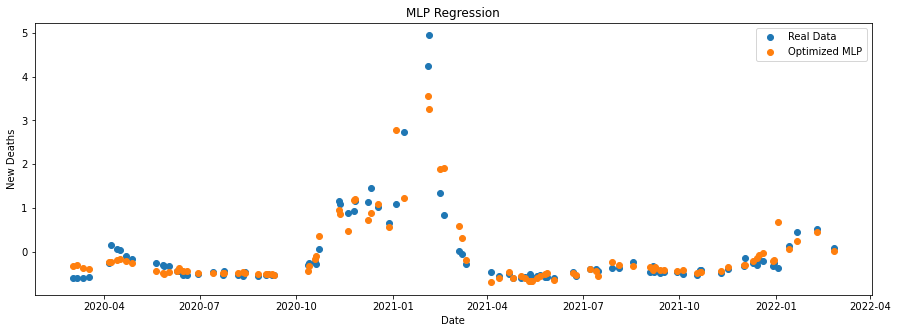

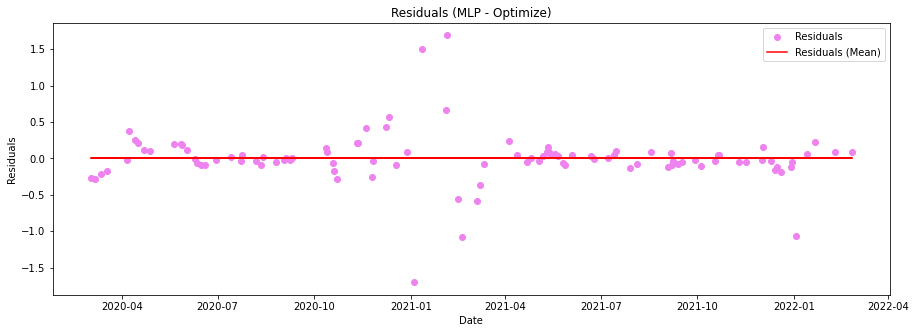

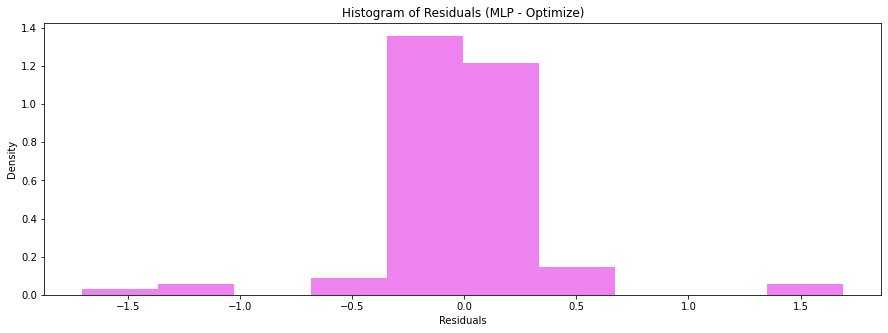

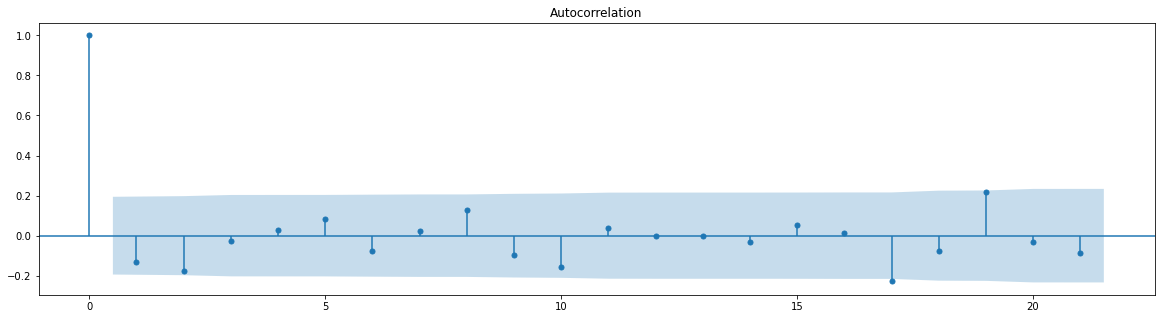

In [37]:
#################### MLP - Final Model ###################

y_MLP = y_ols
x_MLP  = x_ols

X_train_MLP , X_test_MLP , Y_train_MLP , Y_test_MLP  = sklearn.model_selection.train_test_split(x_MLP , y_MLP , test_size = 0.20,random_state=8)

#Fit Model
optimize_MLP = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,activation=activation,alpha=alpha,solver=solver, random_state = 8)
optimize_MLP.fit(X_train_MLP,Y_train_MLP)

# Predict
optimize_MLP_pred=optimize_MLP.predict(X_test_MLP)
optimize_MLP_pred = pd.DataFrame(optimize_MLP_pred)

#Plotting
optimize_MLP_pred.rename(columns = {0: 'MLP Optimized'}, inplace = True)
Y_test_MLP = Y_test_MLP.reset_index()
optimize_MLP_pred['Date'] = Y_test_MLP['Date']
optimize_MLP_pred.set_index('Date', inplace=True)
Y_test_MLP.set_index('Date', inplace=True)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_MLP, 'o', label="Real Data")
ax.plot(optimize_MLP_pred, 'o', label="Optimized MLP")
ax.legend(loc="best")
ax.set_title('MLP Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')

###Residuals
residuals_optimize_MLP_df = pd.DataFrame(Y_test_MLP.values - optimize_MLP_pred.values,columns=Y_test_MLP.columns)
residuals_optimize_MLP_df.rename(columns = {'new_deaths':'Residuals'}, inplace = True)
residuals_optimize_MLP_df.index = Y_test_MLP.index
residuals_optimize_MLP_df = residuals_optimize_MLP_df.reset_index()
residuals_optimize_MLP_df['mean'] = residuals_optimize_MLP_df['Residuals'].mean()
print(residuals_optimize_MLP_df)
# Plotting
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(residuals_optimize_MLP_df['Date'],residuals_optimize_MLP_df['Residuals'], 'o', color = 'violet', label = 'Residuals')
ax.plot(residuals_optimize_MLP_df['Date'],residuals_optimize_MLP_df['mean'],color = 'red', label ='Residuals (Mean)')  
ax.legend(loc="best")
ax.set_title('Residuals (MLP - Optimize)')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
fig,ax = plt.subplots(figsize=(15,5))
ax.hist(residuals_optimize_MLP_df['Residuals'],color = 'violet',density = True)
ax.set_title('Histogram of Residuals (MLP - Optimize)')
ax.set_xlabel('Residuals')
ax.set_ylabel('Density')

# ACF of Residuals
plt.figure(figsize=(20,5))
acf =plot_acf(residuals_optimize_MLP_df['Residuals'], ax=plt.gca())

print("\n")
print("-"*120)

print("\n\033[1mDurbin-Watson Test for Residuals:\033[0m",durbin_watson(Y_test_MLP.values - optimize_MLP_pred.values))
 

In [39]:
############## Random Forest Regressor - Optimize Parameters ##############

y_RF = y_ols
x_RF  = x_ols

X_train_RF , X_test_RF , Y_train_RF , Y_test_RF  = sklearn.model_selection.train_test_split(x_GB , y_GB , test_size = 0.20,random_state=8)

#### Optimizing Paramaters

optimize = {'n_estimators' : randint(100, 1000),'max_depth': randint(2, 10),'min_samples_split':randint(2, 10),'min_samples_leaf': randint(5,15),'max_features':randint(2,10)}

optimize_RF = RandomizedSearchCV(estimator =RandomForestRegressor(), param_distributions = optimize,n_jobs=-1, cv=5, n_iter = 100, random_state = 8)
optimize_RF.fit(X_train_RF,Y_train_RF)


best_params_RF = pd.DataFrame(optimize_RF.best_params_.items())
best_params_RF= best_params_RF.rename(columns={0: 'Predictors',1:'Best Values'}) 
best_score_RF_list = []
best_score_RF_list.append(optimize_RF.best_score_)
best_score_RF = pd.DataFrame(best_score_RF_list)
best_score_RF= best_score_RF.rename(columns={0: 'Best Score'})

display(best_params_RF.style.hide_index())
display(best_score_RF.style.hide_index())

max_depth_opt = best_params_RF.loc[best_params_RF['Predictors'] == 'max_depth', 'Best Values'].item()
max_features_opt = best_params_RF.loc[best_params_RF['Predictors'] == 'max_features', 'Best Values'].item()
min_samples_leaf_opt = best_params_RF.loc[best_params_RF['Predictors'] == 'min_samples_leaf', 'Best Values'].item()
min_samples_split_opt = best_params_RF.loc[best_params_RF['Predictors'] == 'min_samples_split', 'Best Values'].item()
n_estimators_opt = best_params_RF.loc[best_params_RF['Predictors'] == 'n_estimators', 'Best Values'].item()

max_depth_opt = int(max_depth_opt)
max_features_opt = int(max_features_opt)
min_samples_leaf_opt = int(min_samples_leaf_opt)
min_samples_split_opt = int(min_samples_split_opt)
n_estimators_opt = int(n_estimators_opt)

print("\n\033[1mBest Estimator:\033[0m\n", optimize_RF.best_estimator_)

Predictors,Best Values
max_depth,9
max_features,5
min_samples_leaf,5
min_samples_split,9
n_estimators,625


Best Score
0.847210



Best Estimator:
 RandomForestRegressor(max_depth=9, max_features=5, min_samples_leaf=5,
                      min_samples_split=9, n_estimators=625)


      
Random Forest Model (Optimized)


,Coefficients
Predictors,
people_vaccinated,0.307125
temperature,0.198381
new_cases_after_vaccination,0.186049
new_vaccinations_lag1M,0.097136
new_cases_before_vaccination,0.080567
new_vaccinations,0.079795
boosters_lag1M,0.050946


------------------------------------------------------------------------------------------------------------------------
          Date  Residuals      mean
0   2021-09-13  -0.039868  0.015813
1   2020-04-13   0.213495  0.015813
2   2020-08-11  -0.024827  0.015813
3   2020-08-07  -0.036998  0.015813
4   2021-11-10  -0.132232  0.015813
..         ...        ...       ...
97  2020-04-22  -0.019301  0.015813
98  2020-06-19  -0.095461  0.015813
99  2020-08-13   0.031242  0.015813
100 2021-07-14   0.025810  0.015813
101 2021-09-07  -0.063465  0.015813

[102 rows x 3 columns]


------------------------------------------------------------------------------------------------------------------------

Durbin-Watson Test for Residuals: [1.86057557]


------------------------------------------------------------------------------------------------------------------------

MAE - Optimized
MAE: 0.15026796476488738

MSE - Optimized
MSE: 0.07513276145477041

Median Absolute Error - Optimized
Median Abs

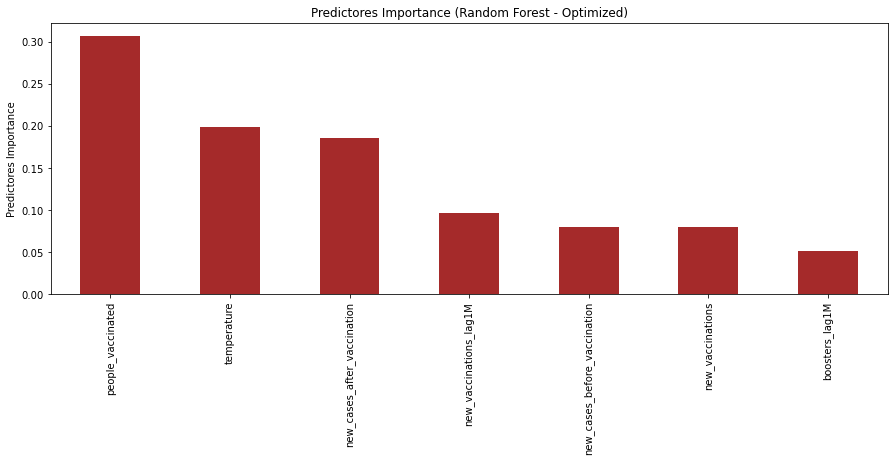

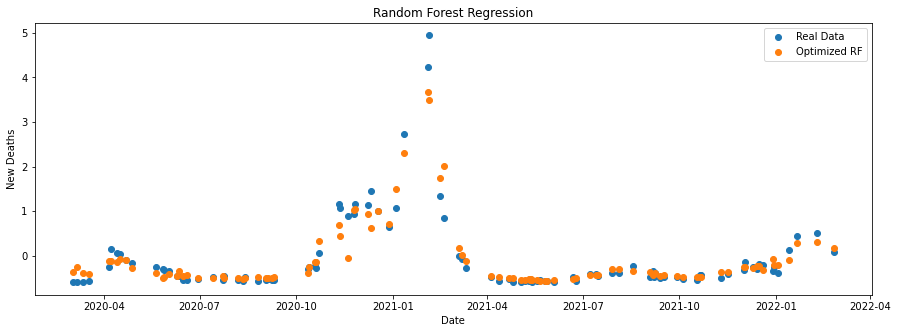

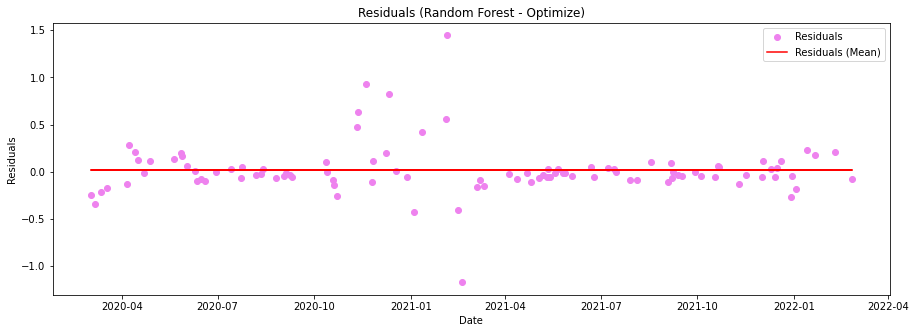

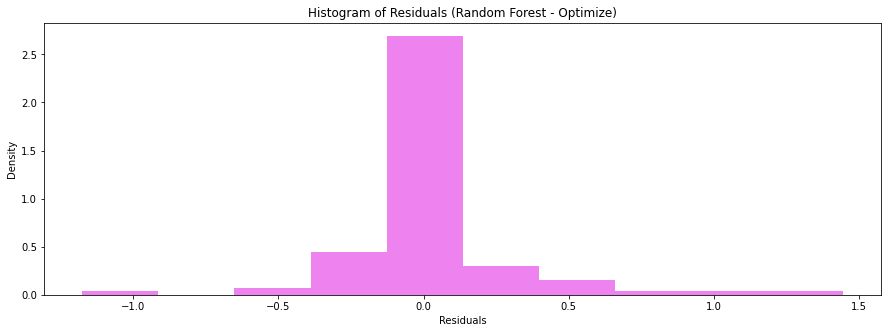

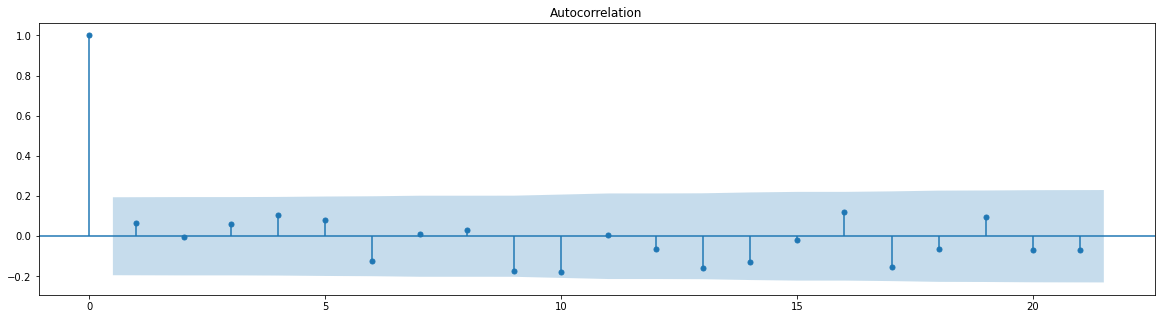

In [40]:
#################### Random Forest - Final Model ###################

y_RF = y_ols
x_RF  = x_ols

X_train_RF , X_test_RF , Y_train_RF , Y_test_RF  = sklearn.model_selection.train_test_split(x_RF , y_RF , test_size = 0.20,random_state=8)

#Fit Model
optimize_RF = RandomForestRegressor(n_estimators=n_estimators_opt,max_depth=max_depth_opt, min_samples_split=min_samples_split_opt, min_samples_leaf=min_samples_leaf_opt,max_features=max_features_opt, random_state = 8)
optimize_RF.fit(X_train_RF,Y_train_RF)

# Predict
predictors_RF=list(X_train_RF)
fig, ax = plt.subplots(figsize=(15,5))
pred_importance= pd.Series(optimize_RF.feature_importances_, predictors_RF).sort_values(ascending=False)
pred_importance.plot.bar( color = 'brown')
plt.ylabel('Predictores Importance')
plt.title('Predictores Importance (Random Forest - Optimized)')
optimize_RF_pred=optimize_RF.predict(X_test_RF)
optimize_RF_pred = pd.DataFrame(optimize_RF_pred)
coefs_optimize_RF_df = pd.DataFrame(optimize_RF.feature_importances_)
coefs_optimize_RF_df.rename(columns = {0:'Coefficients'}, inplace = True)
coefs_optimize_RF_df['Predictors'] = predictors_RF
coefs_optimize_RF_df.set_index('Predictors', inplace = True)
coefs_optimize_RF_df = coefs_optimize_RF_df.sort_values(by=['Coefficients'], ascending = False)
print(" "* 5,"\n\033[1mRandom Forest Model (Optimized)\033[0m")
with pd.option_context('expand_frame_repr', False):
    display(coefs_optimize_RF_df)
    print("-"*120)

#Plotting
optimize_RF_pred.rename(columns = {0: 'Random Forest Optimized'}, inplace = True)
Y_test_RF = Y_test_RF.reset_index()
optimize_RF_pred['Date'] = Y_test_RF['Date']
optimize_RF_pred.set_index('Date', inplace=True)
Y_test_RF.set_index('Date', inplace=True)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_RF, 'o', label="Real Data")
ax.plot(optimize_RF_pred, 'o', label="Optimized RF")
ax.legend(loc="best")
ax.set_title('Random Forest Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')

###Residuals
residuals_optimize_RF_df = pd.DataFrame(Y_test_RF.values - optimize_RF_pred.values,columns=Y_test_RF.columns)
residuals_optimize_RF_df.rename(columns = {'new_deaths':'Residuals'}, inplace = True)
residuals_optimize_RF_df.index = Y_test_RF.index
residuals_optimize_RF_df = residuals_optimize_RF_df.reset_index()
residuals_optimize_RF_df['mean'] = residuals_optimize_RF_df['Residuals'].mean()
print(residuals_optimize_RF_df)
# Plotting
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(residuals_optimize_RF_df['Date'],residuals_optimize_RF_df['Residuals'], 'o', color = 'violet', label = 'Residuals')
ax.plot(residuals_optimize_RF_df['Date'],residuals_optimize_RF_df['mean'],color = 'red', label ='Residuals (Mean)')  
ax.legend(loc="best")
ax.set_title('Residuals (Random Forest - Optimize)')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
fig,ax = plt.subplots(figsize=(15,5))
ax.hist(residuals_optimize_RF_df['Residuals'],color = 'violet',density = True)
ax.set_title('Histogram of Residuals (Random Forest - Optimize)')
ax.set_xlabel('Residuals')
ax.set_ylabel('Density')

# ACF of Residuals
plt.figure(figsize=(20,5))
acf =plot_acf(residuals_optimize_RF_df['Residuals'], ax=plt.gca())

print("\n")
print("-"*120)

print("\n\033[1mDurbin-Watson Test for Residuals:\033[0m",durbin_watson(Y_test_RF.values - optimize_RF_pred.values))


------------------------------------------------------------------------------------------------------------------------
      
Ridge Regression                                                OLS Regression

------------------------------------------------------------------------------------------------------------------------

MAE                                                             MAE
MAE: 0.38567018431453237                                         MAE: 0.3858067622663184

MSE                                                             MSE
MSE: 0.38744956137660697                                         MSE: 0.3875449200746546

Median Absolute Error                                           Median Absolute Error
Median Absolute Error: 0.2887517318580615                       Median Absolute Error: 0.28831533372174056

Explained Variance Score                                        Explained Variance Score
Explained Variance Score: 0.5044076640481499                   Explaine

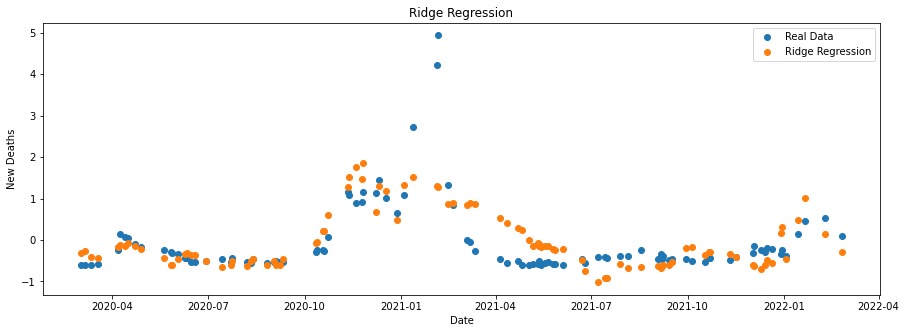

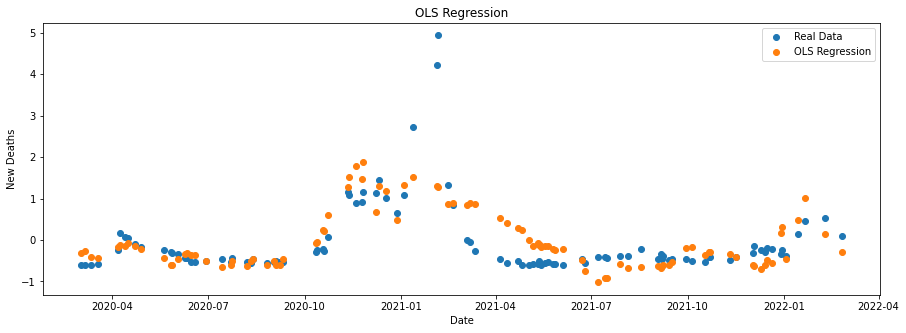

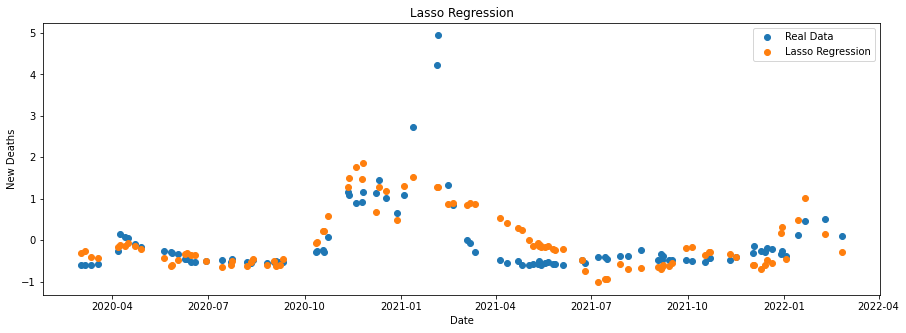

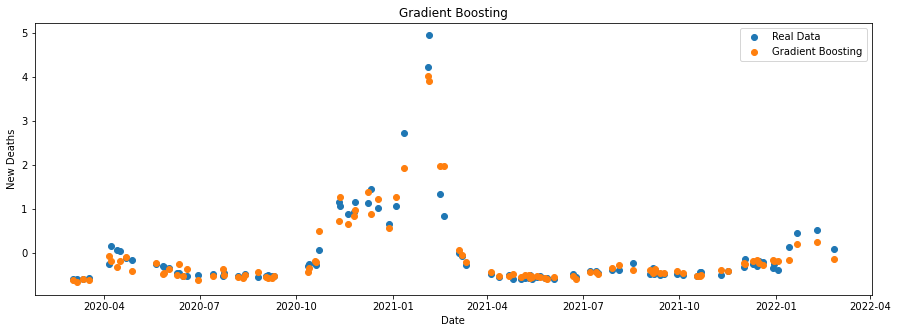

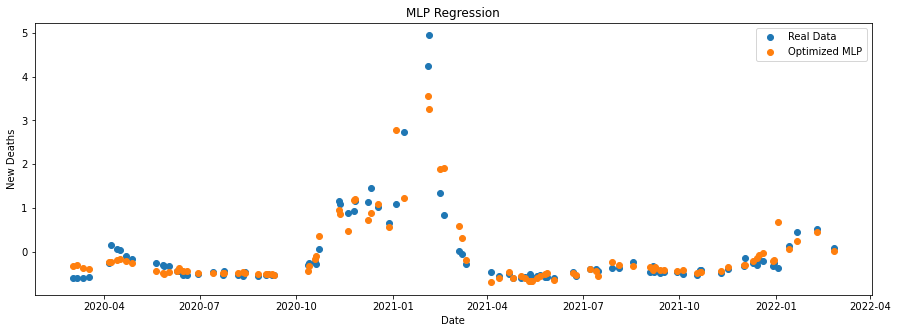

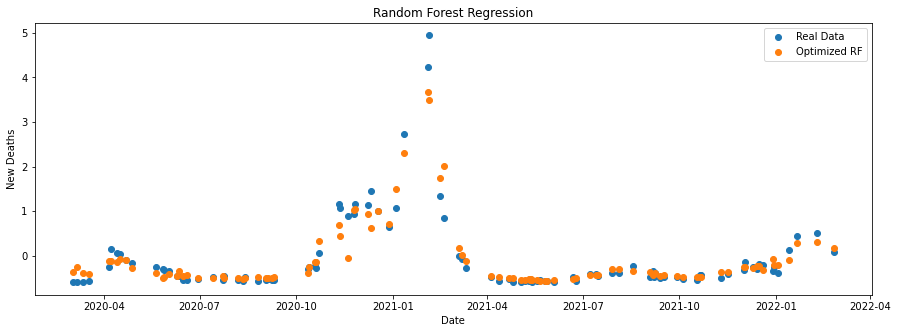

In [41]:
####################### Comparing Models (OLS Regression vs Ridge Regression vs Lasso Regression vs Bayesian Ridge Regression vs Gradient Boosting vs MLP vs Random Forest) #####################
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_Ridge, 'o', label="Real Data")
ax.plot(Y_test_pred_Ridge, 'o', label="Ridge Regression")
ax.set_title('Ridge Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')
ax.legend(loc="best")
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_ols, 'o', label="Real Data")
ax.plot(Y_test_pred_ols, 'o', label="OLS Regression")
ax.set_title('OLS Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')
ax.legend(loc="best")
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_Lasso, 'o', label="Real Data")
ax.plot(Y_test_pred_Lasso, 'o', label="Lasso Regression")
ax.set_title('Lasso Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')
ax.legend(loc="best")
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_GB, 'o', label="Real Data")
ax.plot(optimize_GB_pred, 'o', label="Gradient Boosting")
ax.legend(loc="best")
ax.set_title('Gradient Boosting')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_MLP, 'o', label="Real Data")
ax.plot(optimize_MLP_pred, 'o', label="Optimized MLP")
ax.legend(loc="best")
ax.set_title('MLP Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(Y_test_RF, 'o', label="Real Data")
ax.plot(optimize_RF_pred, 'o', label="Optimized RF")
ax.legend(loc="best")
ax.set_title('Random Forest Regression')
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')

print("-"*120)
print(" "* 5,"\n\033[1mRidge Regression\033[0m"," "* 46, "\033[1mOLS Regression\033[0m\n" )
print("-"*120)

#### OLS and Ridge
# Mean absolute error 
print("\n\033[1mMAE\033[0m"," "*59 ,"\033[1mMAE\033[0m")
print("MAE:" , skl.mean_absolute_error(Y_test_Ridge, Y_test_pred_Ridge)," "* 39 ,"MAE:" , skl.mean_absolute_error(Y_test_ols, Y_test_pred_ols)                                                       )
# Mean squared error 
print("\n\033[1mMSE\033[0m"," "* 59,"\033[1mMSE\033[0m")
print("MSE:" , skl.mean_squared_error(Y_test_Ridge, Y_test_pred_Ridge)," "* 39 ,"MSE:" , skl.mean_squared_error(Y_test_ols, Y_test_pred_ols))
# Median absolute error 
print("\n\033[1mMedian Absolute Error\033[0m"," "* 41,"\033[1mMedian Absolute Error\033[0m")
print("Median Absolute Error:", skl.median_absolute_error(Y_test_Ridge, Y_test_pred_Ridge)," "* 21 ,"Median Absolute Error:", skl.median_absolute_error(Y_test_ols, Y_test_pred_ols)) 
# Explain variance score 
print("\n\033[1mExplained Variance Score\033[0m"," "* 38,"\033[1mExplained Variance Score\033[0m")
print("Explained Variance Score:" , skl.explained_variance_score(Y_test_Ridge, Y_test_pred_Ridge)," "* 17 ,"Explained Variance Score:" , skl.explained_variance_score(Y_test_ols, Y_test_pred_ols) )
# R2 Score
print("\n\033[1mR2 Score\033[0m"," "* 54,"\033[1mR2 Score\033[0m")
print("R2 Score:" , skl.r2_score(Y_test_Ridge, Y_test_pred_Ridge)," "* 34 ,"R2 Score:" , skl.r2_score(Y_test_ols, Y_test_pred_ols))

print("-"*120)
print(" "* 5,"\n\033[1mLasso Regression\033[0m"," "* 45, "\033[1m Gradient Boosting Regression\033[0m\n" )
print("-"*120) 

#### Lasso and Gradient Boosting
# Mean absolute error 
print("\n\033[1mMAE\033[0m"," "*59 ,"\033[1mMAE\033[0m")
print("MAE:" , skl.mean_absolute_error(Y_test_Lasso, Y_test_pred_Lasso)," "* 39 ,"MAE:" , skl.mean_absolute_error(Y_test_GB, optimize_GB_pred))                                                       
# Mean squared error 
print("\n\033[1mMSE\033[0m"," "* 59,"\033[1mMSE\033[0m")
print("MSE:" , skl.mean_squared_error(Y_test_Lasso, Y_test_pred_Lasso)," "* 39 ,"MSE:" , skl.mean_squared_error(Y_test_GB, optimize_GB_pred))
# Median absolute error 
print("\n\033[1mMedian Absolute Error\033[0m"," "* 41,"\033[1mMedian Absolute Error\033[0m")
print("Median Absolute Error:", skl.median_absolute_error(Y_test_Lasso, Y_test_pred_Lasso)," "* 20 ,"Median Absolute Error:", skl.median_absolute_error(Y_test_GB, optimize_GB_pred)) 
# Explain variance score 
print("\n\033[1mExplained Variance Score\033[0m"," "* 38,"\033[1mExplained Variance Score\033[0m")
print("Explained Variance Score:" , skl.explained_variance_score(Y_test_Lasso, Y_test_pred_Lasso)," "* 18 ,"Explained Variance Score:" , skl.explained_variance_score(Y_test_GB, optimize_GB_pred) )
# R2 Score
print("\n\033[1mR2 Score\033[0m"," "* 54,"\033[1mR2 Score\033[0m")
print("R2 Score:" , skl.r2_score(Y_test_Lasso, Y_test_pred_Lasso)," "* 34 ,"R2 Score:" , skl.r2_score(Y_test_GB, optimize_GB_pred))

print("-"*120)
print(" "* 5,"\n\033[1mMLP Regression\033[0m"," "* 46, "\033[1mRandom Forest Regression\033[0m\n" )
print("-"*120)

### MLP and Random Forest
# Mean absolute error 
print("\n\033[1mMAE\033[0m"," "*59 ,"\033[1mMAE\033[0m")
print("MAE:" , skl.mean_absolute_error(Y_test_GB, optimize_MLP_pred)," "* 39 ,"MAE:" , skl.mean_absolute_error(Y_test_MLP, optimize_RF_pred))                                                   
# Mean squared error 
print("\n\033[1mMSE\033[0m"," "* 59,"\033[1mMSE\033[0m")
print("MSE:" , skl.mean_squared_error(Y_test_GB,optimize_MLP_pred)," "* 39 ,"MSE:" , skl.mean_squared_error(Y_test_MLP, optimize_RF_pred))
# Median absolute error 
print("\n\033[1mMedian Absolute Error\033[0m"," "* 41,"\033[1mMedian Absolute Error\033[0m")
print("Median Absolute Error:", skl.median_absolute_error(Y_test_GB, optimize_MLP_pred)," "* 20 ,"Median Absolute Error:", skl.median_absolute_error(Y_test_MLP, optimize_RF_pred))
# Explain variance score 
print("\n\033[1mExplained Variance Score\033[0m", " " * 38, "\033[1mExplained Variance Score\033[0m")
print("Explained Variance Score:" , skl.explained_variance_score(Y_test_GB, optimize_MLP_pred)," "* 18 ,"Explained Variance Score:" , skl.explained_variance_score(Y_test_MLP, optimize_RF_pred))
# R2 Score
print("\n\033[1mR2 Score\033[0m"," "* 54,"\033[1mR2 Score\033[0m")
print("R2 Score:" , skl.r2_score(Y_test_GB, optimize_MLP_pred)," "* 34 ,"R2 Score:" , skl.r2_score(Y_test_MLP, optimize_RF_pred))

print("-"*120)
print("\n")
print("-"*120) 